# Построение прогнозной модели классификации для оценки вероятности снижения покупательской активности клиента

## Резюме исследования

**Заголовок:** Исследование покупательской активности клиента с целью оценки вероятности её снижения в ближайшие три месяца

**Описание проекта:** Руководство интернет-магазина "В один клик" поручило разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Цель исследования:** Выявить закономерности и факторы, определяющие снижение покупательской активности клиента на исторических данных заказчика. Спрогнозировать заданные показатели на тестовой выборке. Дать рекомендации по повышению покупательнской активности по сегментированным клиентам

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категриальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение модели классификации, оценка её качества
* Анализ важности признаков
* Сегментация клиентов
* Формирование рекомендаций по повышению покупательнской активности по сегментированным клиентам

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

## Описание данных

`market_file.csv`

**Основная таблица** с данными о поведении покупателей.

| Поле                        | Описание                                                                 |
|----------------------------|--------------------------------------------------------------------------|
| id                         | Уникальный идентификатор покупателя в базе данных                       |
| Покупательная активность   | Класс активности: «снизилась» или «прежний уровень» (целевой признак)    |
| Тип сервиса                | Уровень сервиса: «премиум» или «стандарт»                                |
| Разрешить сообщать         | Флаг согласия на получение дополнительных предложений                    |
| Маркет_актив_6_мес         | Среднее количество коммуникаций за последние 6 месяцев                   |
| Маркет_актив_тек_мес       | Количество коммуникаций в текущем месяце                                |
| Длительность               | Количество дней с момента регистрации                                   |
| Акционные_покупки          | Доля покупок по акции за последние 6 месяцев                            |
| Популярная_категория       | Наиболее часто покупаемая категория товаров                            |
| Средний_просмотр_категорий_за_визит | Среднее количество просмотренных категорий за визит              |
| Неоплаченные_продукты_штук_квартал | Количество товаров в корзине без оплаты за 3 месяца             |
| Ошибка_сервиса             | Количество технических сбоев за последние 3 месяца                       |
| Страниц_за_визит           | Среднее количество просмотренных страниц за визит                        |

`market_money.csv`

**Таблица выручки** с данными о тратах покупателей.

| Поле    | Описание                          |
|---------|-----------------------------------|
| id      | Идентификатор покупателя          |
| Период  | Временной период (текущий/предыдущий месяц) |
| Выручка | Сумма потраченных средств         |

`market_time.csv`

**Таблица времени** с данными о длительности сессий.

| Поле    | Описание                   |
|---------|---------------------------|
| id      | Идентификатор покупателя  |
| Период  | Временной период          |
| минут   | Время на сайте в минутах  |

`money.csv`

**Таблица прибыли** с данными о доходах продавца.

| Поле    | Описание                   |
|---------|---------------------------|
| id      | Идентификатор покупателя  |
| Прибыль | Среднемесячная прибыль от покупателя |

Взаимосвязи таблиц
* Все таблицы связаны через поле **id** (идентификатор покупателя)
* **market_file.csv** содержит основную информацию о поведении
* **market_money.csv** дополняет данными о расходах
* **market_time.csv** предоставляет информацию о времени на сайте
* **money.csv** показывает прибыль от каждого покупателя

Возможные сценарии использования
* Анализ покупательской активности
* Оценка эффективности маркетинговых кампаний
* Сегментация клиентов
* Прогнозирование оттока
* Оптимизация сервиса


## Импорт библиотек

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install 'optuna-integration[sklearn]' -q
!pip install shap -q
!pip install numpy==1.22 -q
!pip install matplotlib==3.5.3 -q

In [2]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import phik
import time
import shap

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold

from sklearn.inspection import permutation_importance

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from typing import Union, List, Dict

# Импорт метода для проверки нормальности распределения
from scipy.stats import shapiro

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Классы и функции

### Класс для обработки датасета

In [3]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 1.0]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string']).columns
        if string_columns.empty:
            print('Строковых столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_string_columns(self, column_name=None): # Выводит уникальные значения в строковых столбцах
        if column_name:
            columns = [column_name]
        else:
            columns = self.get_string_columns()
        
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            print(unique_values)
            print('-' * 30)
    
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()
    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}_mod' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Класс для обработки столбцов

In [4]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self): # Функция для ознакомления с количественными показателями
        return self.series.describe()
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        self.data[self.column_name] = self.data[self.column_name].astype(new_type)
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Класс для обработки групп датасетов

In [5]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)
            
    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Класс для построения графиков

In [6]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            num_bins = df[x_label].dropna().shape[0]
            bins = int(np.floor(np.log2(num_bins)) + 1)
            
            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='step',
                ax=ax,
                bins=bins
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in x_list + [y, hue] if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            for category in df[hue].unique():
                subset = df[df[hue] == category]
                sns.regplot(
                    data=subset,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax,
                    label=category
                )
                
            ax.set_title(f'Зависимость {y} от {x_label}')
            ax.legend().set_title(hue)
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Загрузка данных и анализ общей информации

### Загрузка данных

In [7]:
# Загрузим датафреймы
df_market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', sep=',')

df_revenue = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')

df_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')

df_profit = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

In [8]:
# Инициализируем все датафреймы
df_market = Data(df_market)
df_revenue = Data(df_revenue)
df_time = Data(df_time)
df_profit = Data(df_profit)

# Составим словарь с именами датафреймов
datasets = {
    'df_market': df_market, 
    'df_revenue': df_revenue, 
    'df_time': df_time,
    'df_profit':df_profit
}

# Составим словарь перевода имен столбцов
dict_column_translations = {
    'id': 'user_id',
    'Покупательская активность': 'purchase_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_communications',
    'Маркет_актив_6_мес': 'avg_6month_marketing_activity',
    'Маркет_актив_тек_мес': 'curr_month_marketing_activity',
    'Длительность': 'days_since_registration',
    'Акционные_покупки': 'avg_6month_promo_purchase_share',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'avg_categories_viewed_per_session',
    'Неоплаченные_продукты_штук_квартал': 'total_3month_unpaid_products',
    'Ошибка_сервиса': 'total_3month_service_errors',
    'Страниц_за_визит': 'avg_3month_page_views_per_visit',
    'Период': 'period',
    'Выручка': 'revenue_per_month',
    'минут': 'session_minutes',
    'Прибыль': 'avg_3month_profit'
}

# Передаем объекты для последующего вывода информации
manager = DatasetManager(datasets)

### Знакомство с данными

In [9]:
# Ознакомимся с данными
manager.print_head_all(10)

Датасет: df_market



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.10,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.70,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.90,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


------------------------------
Датасет: df_revenue



,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60
5,215349,предыдущий_месяц,5216.00
6,215350,препредыдущий_месяц,4826.00
7,215350,текущий_месяц,5058.40
8,215350,предыдущий_месяц,5457.50
9,215351,текущий_месяц,6610.40


------------------------------
Датасет: df_time



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


------------------------------
Датасет: df_profit



,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"
5,215353,"3,95"
6,215354,"3,62"
7,215355,"5,26"
8,215356,"4,93"
9,215357,"4,66"


------------------------------


### Анализ общей информации

In [10]:
# Проанализируем общую информацию
manager.show_info_all()

Датасет: df_market

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сер

### Промежуточные выводы

**df_market**

* **Количество строк:** 1300
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_revenue**

* **Количество строк:** 3900
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_time**

* **Количество строк:** 2600
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_profit**

* **Количество строк:** 1300
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** требуется корректировка
  * Прибыль -> float

##  Предобработка данных

### Изменение типов данных

In [11]:
# Изменение типа данных для датасета ferma
df_profit.convert_columns_to_float(['Прибыль'], replacements={',':'.'})

Тип данных для столбца Прибыль изменен на float64


In [12]:
# Проверим результат изменения
df_profit.data['Прибыль'].dtypes

dtype('float64')

### Изменение имён столбцов

In [13]:
# Запустим функцию замены символов по всем датасетам
manager.replace_multiple_column_name_all(dict_column_translations)

Датасет: df_market

Index(['user_id', 'purchase_activity', 'service_type', 'allow_communications',
       'avg_6month_marketing_activity', 'curr_month_marketing_activity',
       'days_since_registration', 'avg_6month_promo_purchase_share',
       'popular_category', 'avg_categories_viewed_per_session',
       'total_3month_unpaid_products', 'total_3month_service_errors',
       'avg_3month_page_views_per_visit'],
      dtype='object')
------------------------------
Датасет: df_revenue

Index(['user_id', 'period', 'revenue_per_month'], dtype='object')
------------------------------
Датасет: df_time

Index(['user_id', 'period', 'session_minutes'], dtype='object')
------------------------------
Датасет: df_profit

Index(['user_id', 'avg_3month_profit'], dtype='object')
------------------------------


### Обработка дубликатов

#### Явные дубликаты

In [14]:
# Посмотрим на явные дубликаты в датасетах
manager.get_duplicate_rows_all()

Датасет: df_market

------------------------------
Датасет: df_revenue

------------------------------
Датасет: df_time

------------------------------
Датасет: df_profit

------------------------------


Явные дубликаты не обнаружены

#### Неявные дубликаты

In [15]:
# Выводим уникальные значения в столбцах с строковым типом данных
manager.show_unique_vals_string_columns_all()

Имя датасета: df_market

Уникальные значения для столбца: purchase_activity
Количество уникальных значений: 2
['Прежний уровень', 'Снизилась']
------------------------------
Уникальные значения для столбца: service_type
Количество уникальных значений: 3
['премиум', 'стандарт', 'стандартт']
------------------------------
Уникальные значения для столбца: allow_communications
Количество уникальных значений: 2
['да', 'нет']
------------------------------
Уникальные значения для столбца: popular_category
Количество уникальных значений: 6
['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: df_revenue

Уникальные значения для столбца: period
Количество уникальных значений: 3
['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц']
------------------------------

/-/-/-/-/-/-/-

Мы видим, что в столбце `service_type` датасета **df_market** и столбце `period` датасета **df_time** есть опечатки. Исправим их.

In [16]:
# Замена значений из словаря на корректный вариант
df_market.process_string_columns(
    columns=['service_type', 'popular_category'],
    replacements={'стандартт':'стандарт', 'Косметика и аксесуары':'Косметика и аксесcуары'}
)

Уникальные значения для столбца: service_type
Количество уникальных значений: 2
['премиум', 'стандарт']
------------------------------
Уникальные значения для столбца: popular_category
Количество уникальных значений: 6
['Домашний текстиль', 'Косметика и аксесcуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей']
------------------------------


In [17]:
# Замена значений из словаря на корректный вариант
df_time.process_string_columns(
    columns=['period'],
    replacements={'предыдцщий_месяц':'предыдущий_месяц'}
)

Уникальные значения для столбца: period
Количество уникальных значений: 2
['предыдущий_месяц', 'текущий_месяц']
------------------------------


#### Промежуточные выводы

* Тип данных для столбца `profit` датасета **df_profit** изменен на float64

* Имена столбцов унифицированы: приведены к виду snake_case, переведены на английский язык

* Явные и неявные дубликаты обработаны

## Исследовательский анализ данных

### Статистический анализ данных

#### Описательная статистика

In [18]:
# Посмотрим на параметры столбцов с числовыми значениями
manager.describe_numeric_all()

Датасет: df_market



,user_id,avg_6month_marketing_activity,curr_month_marketing_activity,days_since_registration,avg_6month_promo_purchase_share,avg_categories_viewed_per_session,total_3month_unpaid_products,total_3month_service_errors,avg_3month_page_views_per_visit
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
95%,216582.05,5.80,5.00,997.05,0.95,6.00,7.00,8.00,15.00
99%,216634.01,6.30,5.00,1051.00,0.99,6.00,9.00,9.00,18.00
99.5%,216640.51,6.60,5.00,1061.00,0.99,6.00,9.00,9.00,18.50


------------------------------
Датасет: df_revenue



,user_id,revenue_per_month
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
95%,216582.05,6226.52
99%,216634.01,6957.74
99.5%,216641.00,7160.45


------------------------------
Датасет: df_time



,user_id,session_minutes
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
95%,216582.05,20.00
99%,216634.01,22.00
99.5%,216641.00,23.00


------------------------------
Датасет: df_profit



,user_id,avg_3month_profit
count,1300.00,1300.00
mean,215997.50,4.00
std,375.42,1.01
min,215348.00,0.86
25%,215672.75,3.30
50%,215997.50,4.04
75%,216322.25,4.67
95%,216582.05,5.58
99%,216634.01,6.40
99.5%,216640.51,6.69


------------------------------


По показателю дохода в датасете **df_revenue** имеется явно выраженный выброс. В остальных столбцах выбросы не обнаружены.

In [19]:
# Фильтруем датасет для выявления выбросов
df_revenue.data.loc[df_revenue.data['revenue_per_month'] > 7_600]

,user_id,period,revenue_per_month
98,215380,текущий_месяц,106862.20
262,215435,текущий_месяц,7605.30
435,215493,текущий_месяц,7799.40


Видим, что выброс всего один. Посмотрим показатели дохода по этому пользователю.

In [20]:
# Фильтруем датасет для выявления выбросов
df_revenue.data.loc[df_revenue.data['user_id'] == 215380]

,user_id,period,revenue_per_month
96,215380,препредыдущий_месяц,5051.00
97,215380,предыдущий_месяц,6077.00
98,215380,текущий_месяц,106862.20


* Данные по доходу от данного пользователя за прошлый и позапрошлый месяцы составили 5 и 6 тыс. у.е.
* Значение в 106 тыс. у.е. представляется аномальным.
* Обработаем аномалию, убрав первые 2 цифры в начале.
* В итоге должны получить значение в 6,9 тыс. у.е.

In [21]:
# Присваиваем новое значение
df_revenue.data.loc[df_revenue.data['revenue_per_month'] == 106_862.20, 'revenue_per_month'] = 6_862.20

# Смотрим на результат
df_revenue.data.loc[df_revenue.data['revenue_per_month'] == 6_862.20]

,user_id,period,revenue_per_month
98,215380,текущий_месяц,6862.20


Замена аномального значения проведена успешно.

#### Построение диаграмм размаха

**Диаграмма размаха по признакам датасета df_market**

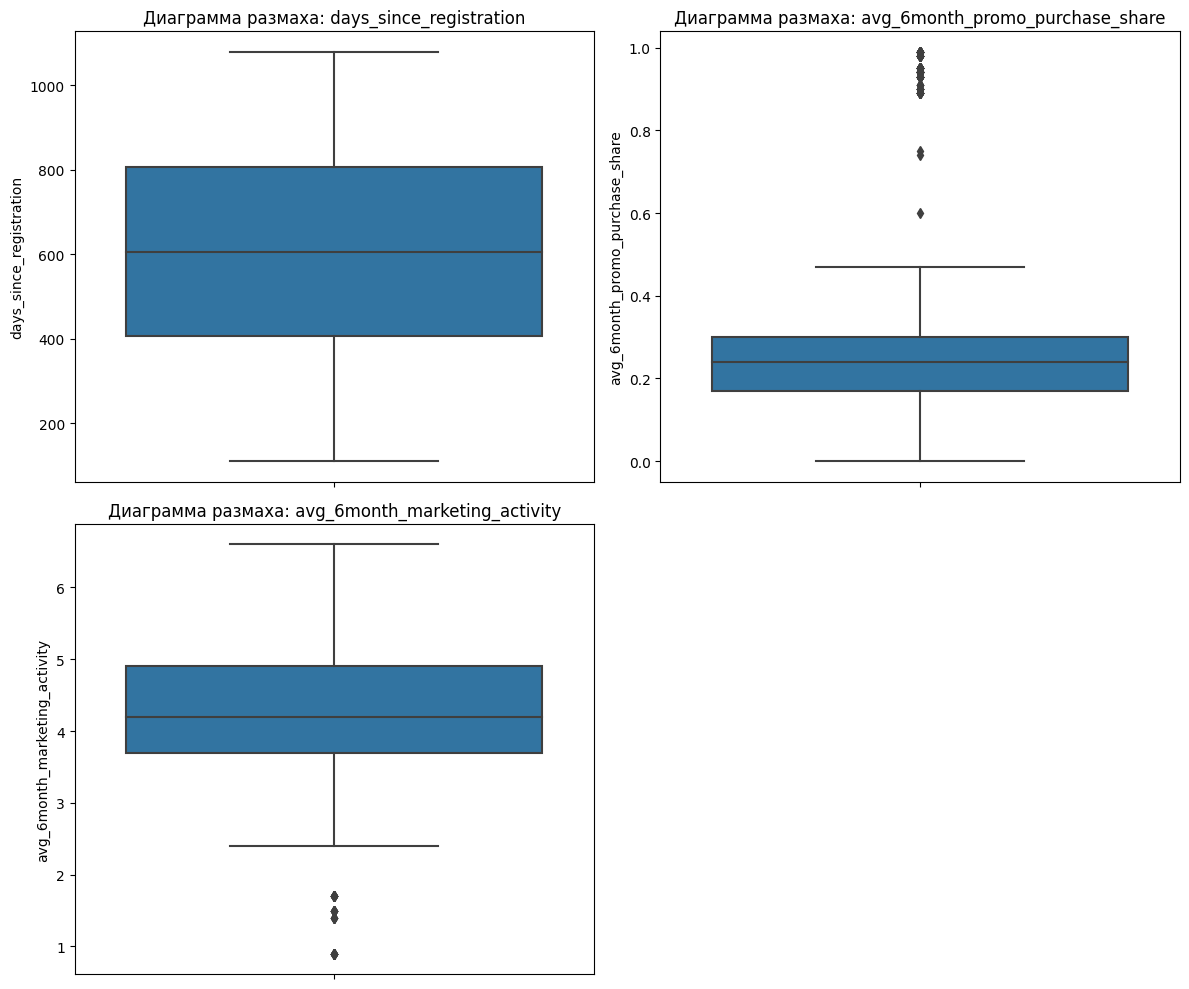

In [22]:
# Создаем визуализатор
viz_market = Visualizer(df_market.data)

# Строим ящик с усами
viz_market.boxplot(y=['days_since_registration', 'avg_6month_promo_purchase_share', 'avg_6month_marketing_activity'])

**Диаграмма размаха по признакам датасета df_revenue**

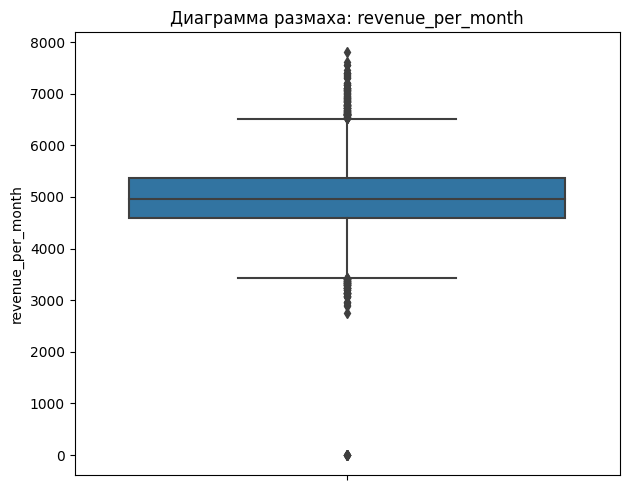

In [23]:
# Создаем визуализатор
viz_revenue = Visualizer(df_revenue.data)

# Строим ящик с усами
viz_revenue.boxplot(y=['revenue_per_month'])

**Диаграмма размаха по признакам датасета df_revenue в разрезе периода**

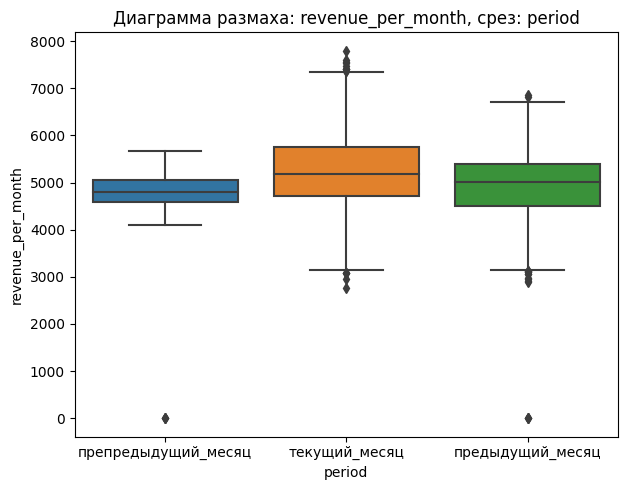

In [24]:
# Строим ящик с усами
viz_revenue.boxplot(y=['revenue_per_month'], x='period')

**Диаграмма размаха по признакам датасета df_time**

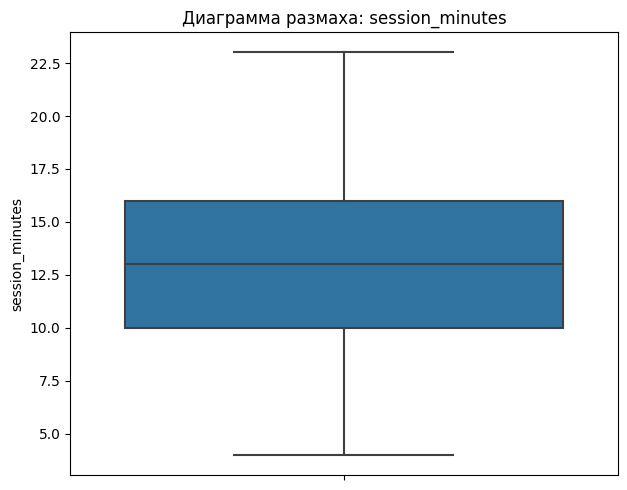

In [25]:
# Создаем визуализатор
viz_time = Visualizer(df_time.data)

# Строим ящик с усами
viz_time.boxplot(y=['session_minutes'])

**Диаграмма размаха по признакам датасета df_time в разрезе периода**

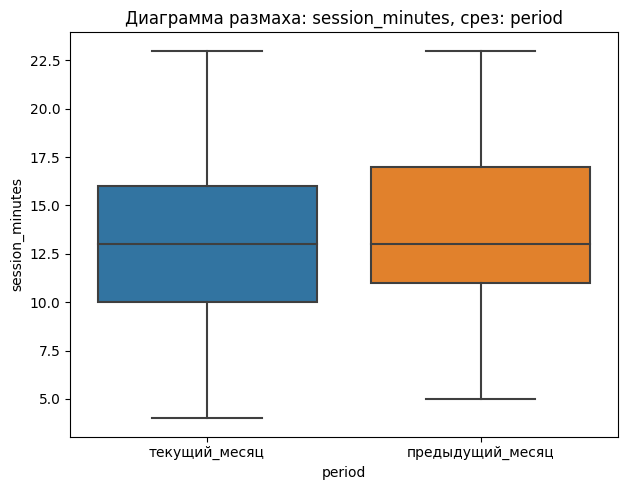

In [26]:
# Строим ящик с усами
viz_time.boxplot(y=['session_minutes'], x='period')

**Диаграмма размаха по признакам датасета df_profit**

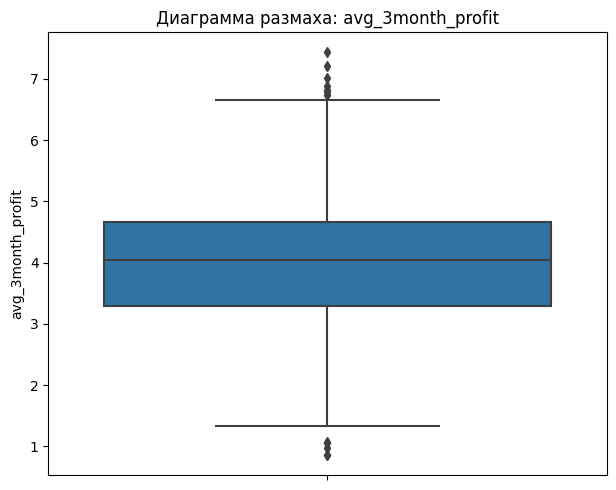

In [27]:
# Создаем визуализатор
viz_profit = Visualizer(df_profit.data)

# Строим ящик с усами
viz_profit.boxplot(y=['avg_3month_profit'])

#### Комментарии к диаграммам размаха

**df_market**

* **Ниже указаны медианы значений по признакам:**
  * `days_since_registration`: 600 (МР в диапазоне 400-800)
  * `avg_6month_promo_purchase_share`: 0.2 (МР в диапазоне 0.18-0.3)
  * `avg_6month_marketing_activity`: 4.2
* **Обнаружены выбросы по признакам:**
  * `avg_6month_promo_purchase_share` в области более 0.5

**df_revenue**

* **Медиана значений по признаку** `revenue_per_month` составила 5000 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6500 у.е. и ниже 3000 у.е.
* **Наибольшая сумма выручки:** зафиксирована в текущем месяце, но если говорить о средних значениях, то они аналогичны для всех 3-х периодов и держатся в районе 5000 у.е.

**df_time**

* **Медиана значений по признаку** `session_minutes` составила 13 минут
* **Выбросы не обнаружены**

**df_profit**

* **Медиана значений по признаку** `avg_3month_profit` составила 4 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6.5 у.е. и ниже 1.5 у.е.

#### Построение диаграмм распределения

**Диаграммы распределения по признакам датасета df_market**

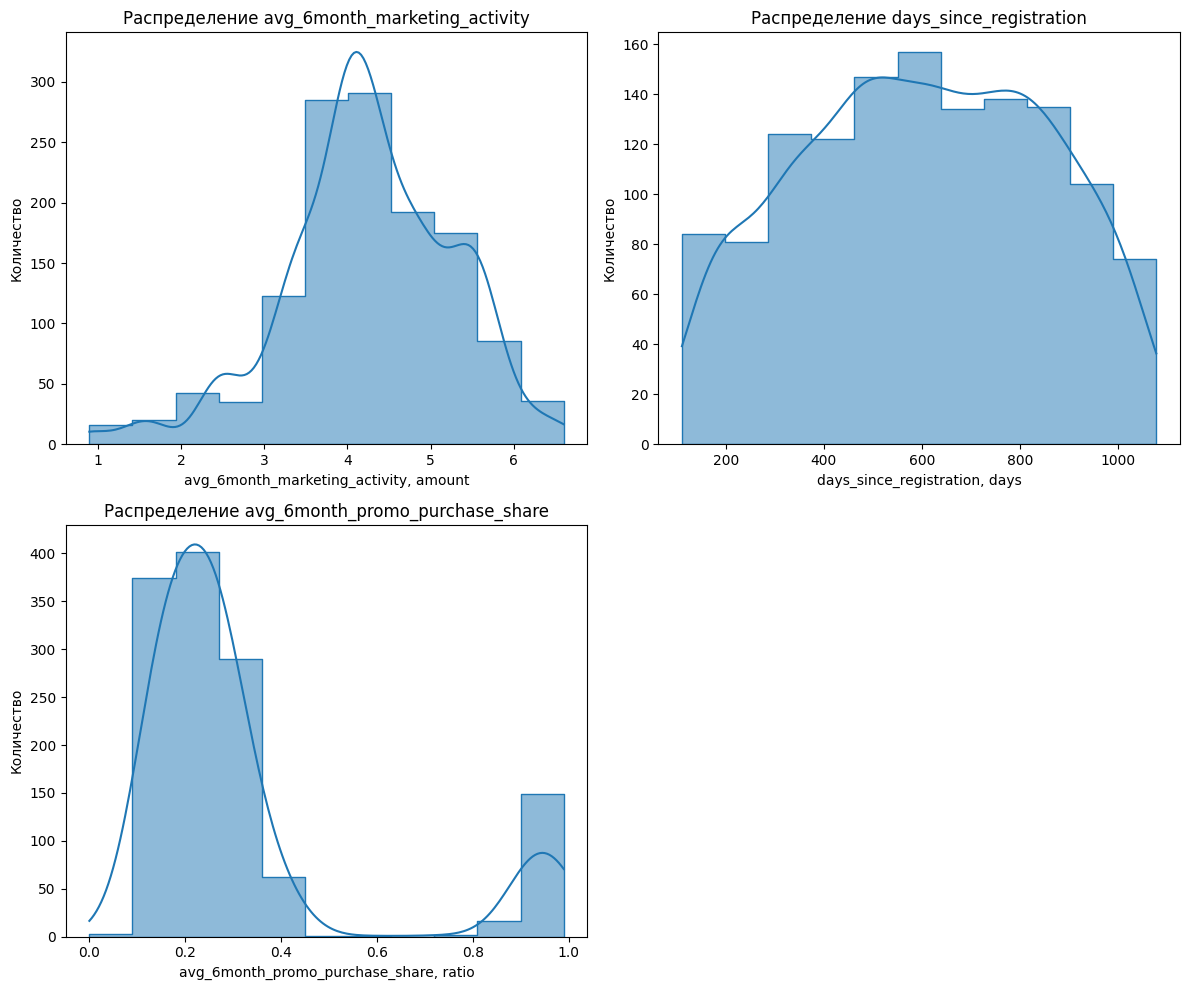

In [28]:
# Строим график
viz_market.histplot(x=['avg_6month_marketing_activity', 'days_since_registration', 'avg_6month_promo_purchase_share'], measurement=['amount', 'days', 'ratio'])

In [29]:
# Создаем список столбцов для проведения теста Шапиро-Уилка
df_market_columns = ['avg_6month_marketing_activity', 'days_since_registration', 'avg_6month_promo_purchase_share']

# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
for column in df_market_columns:
    display(f'Результат теста Шапиро_Уилка для столбца {column}: {shapiro(df_market.data[column])}')
    print('*' * 5)

'Результат теста Шапиро_Уилка для столбца avg_6month_marketing_activity: ShapiroResult(statistic=0.9779577255249023, pvalue=3.3563990887823525e-13)'

*****


'Результат теста Шапиро_Уилка для столбца days_since_registration: ShapiroResult(statistic=0.9726996421813965, pvalue=5.791480627183451e-15)'

*****


'Результат теста Шапиро_Уилка для столбца avg_6month_promo_purchase_share: ShapiroResult(statistic=0.6621230840682983, pvalue=5.605193857299268e-45)'

*****


**Вывод о нормальности распределения**
* p_value для значений всех столбцов значительно меньше 0.05, отвергаем нулевую гипотезу - значения по столбцам `avg_6month_marketing_activity`, `days_since_registration`, `avg_6month_promo_purchase_share` **НЕ распределены нормально**.

**Диаграммы распределения по признакам датасета df_revenue**

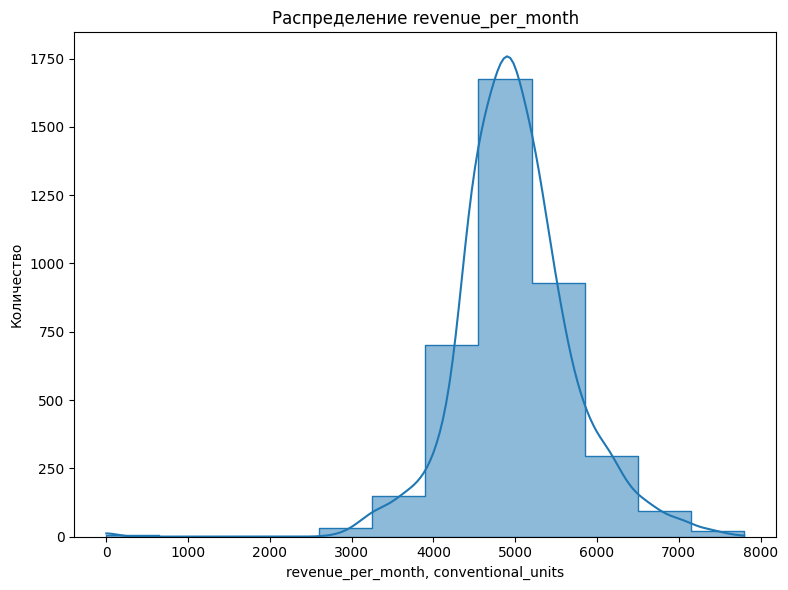

In [30]:
# Строим график
viz_revenue.histplot(x=['revenue_per_month'], measurement=['conventional_units'])

In [31]:
# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
shapiro(df_revenue.data['revenue_per_month'])

ShapiroResult(statistic=0.9592301845550537, pvalue=9.180506848672018e-32)

**Вывод о нормальности распределения**
* Нулевая гипотеза звучит так: переменная распределена нормально. Для подтверждения гипотезы требуются следующие условия: значение statistic близко или равно 1, p_value > 0.05.
* Значение p_value значительно меньше 0.05, отвергаем нулевую гипотезу - выручка в месяц (revenue_per_month) **НЕ распределена нормально**.

**Диаграммы распределения по признакам датасета df_time**

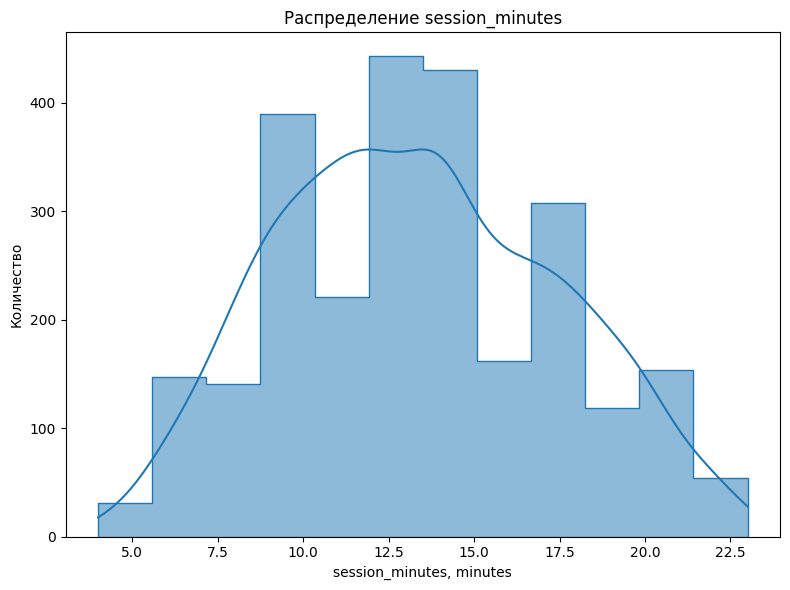

In [32]:
# Строим график
viz_time.histplot(x=['session_minutes'], measurement=['minutes'])

In [33]:
# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
shapiro(df_time.data['session_minutes'])

ShapiroResult(statistic=0.9825900793075562, pvalue=2.5159861346741586e-17)

**Вывод о нормальности распределения**
* Значение p_value значительно меньше 0.05, отвергаем нулевую гипотезу - продолжительность сессий (session_minutes) **НЕ распределена нормально**.

**Диаграммы распределения по признакам датасета df_profit**

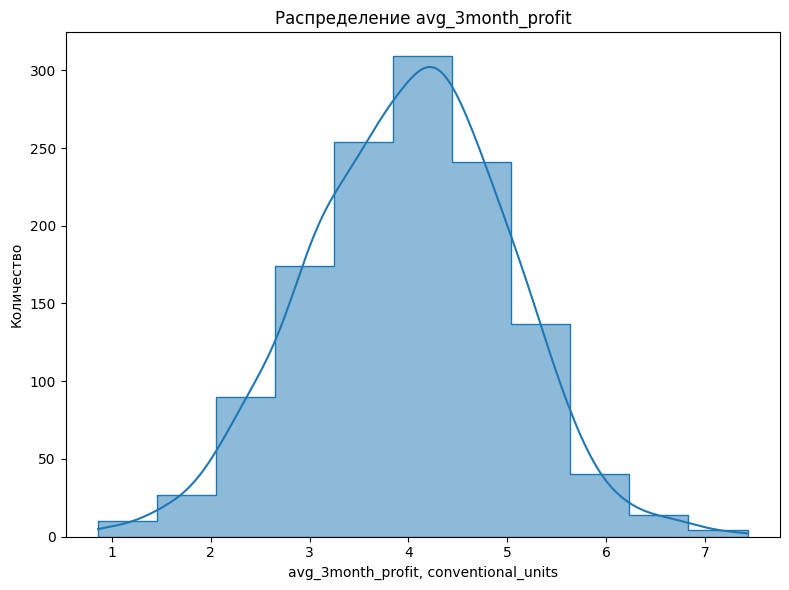

In [34]:
# Строим график
viz_profit.histplot(x=['avg_3month_profit'], measurement=['conventional_units'])

In [35]:
# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
shapiro(df_profit.data['avg_3month_profit'])

ShapiroResult(statistic=0.9983819723129272, pvalue=0.25812551379203796)

**Вывод о нормальности распределения**
* Значение p_value значительно больше 0.05, показатель статистики составил 0.99 (близко к 1), не отвергаем нулевую гипотезу - среднемесячная прибыль (avg_3month_profit) **распределена нормально**.

#### Комментарии к диаграммам распределения

**df_market**

  * `avg_6month_marketing_activity`: распределение с пиком в области 4
  * `days_since_registration`: распределение с относительно пологими склонами, модальное значение наблюдается при значении 500 дней со дня регистрации
  * `avg_6month_promo_purchase_share`: распределение с пиком в области 0.2, заметен локальный пик в области 0.9-1.0

**df_revenue**

* `revenue_per_month`: распределение имеет нормальный характер с пиком в области 5000 у.е., на график видны редкие значения на интервале от 0 до 3000 у.е.

**df_time**

* `session_minutes`: распределение с модальными значениями на интервале 12-13 минут, также имеются пустоты в интервалах 10-11 минут, 16-17 минут

**df_profit**

* `avg_3month_profit`: распределение имеет нормальный характер с пиком в области 4.5 у.е.

#### Построение диграмм частот

**Диаграммы частот по признакам датасета df_market**

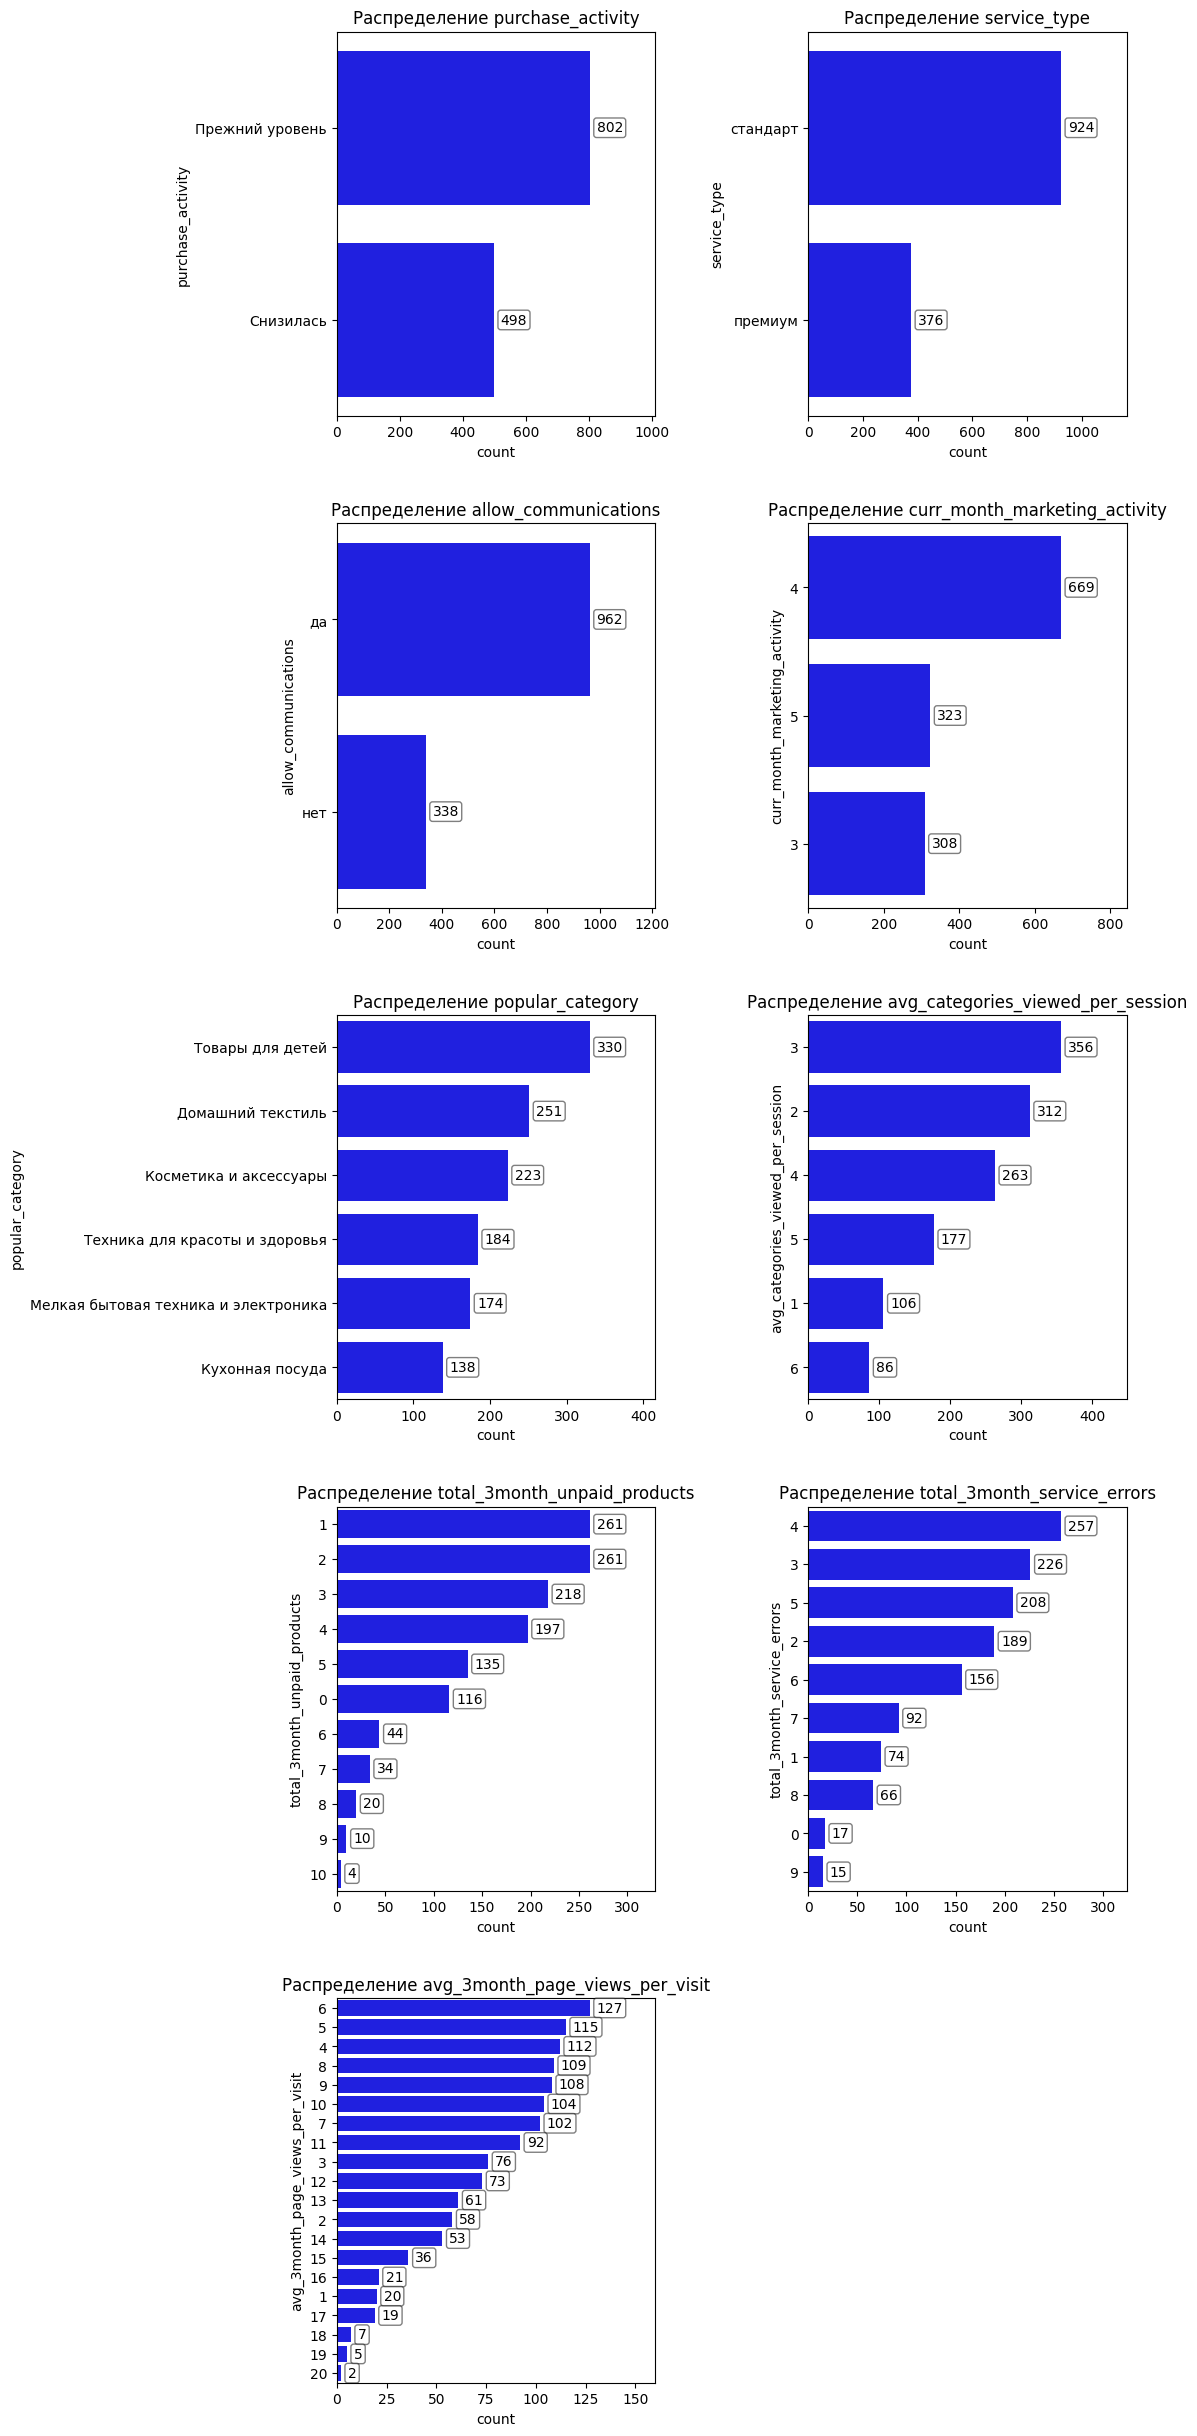

In [36]:
# Строим график
viz_market.barplot(x=['purchase_activity', 'service_type', 'allow_communications', 'curr_month_marketing_activity', \
                      'popular_category', 'avg_categories_viewed_per_session', 'total_3month_unpaid_products', \
                      'total_3month_service_errors', 'avg_3month_page_views_per_visit'])

**Диаграммы частот по признакам датасета df_revenue**

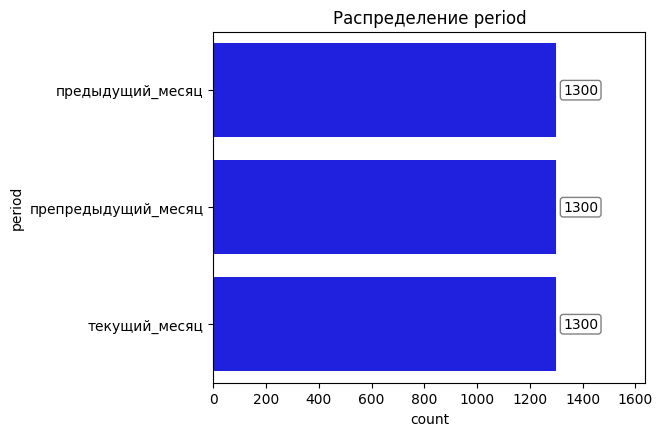

In [37]:
# Строим график
viz_revenue.barplot(x=['period'])

**Диаграммы частот по признакам датасета df_time**

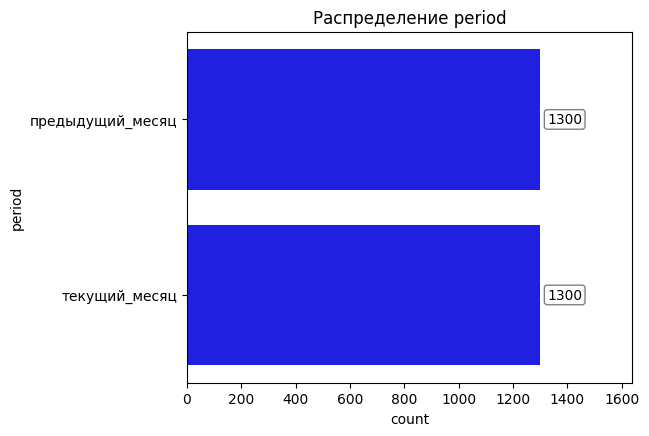

In [38]:
# Строим график
viz_time.barplot(x=['period'])

#### Комментарии к диаграммам частот

**df_market** выборка обладает следующими характеристиками:

  * `purchase_activity`: большая чать клиентов относится к категории с постоянной покупательской способностью

Коммуникации с клиентом
  * `service_type`: клиент имеет подписку "стандарт"
  * `allow_communications`: клиент даёт разрешение на доп. предложения о товарах
  * `curr_month_marketing_activity`: клиент получает 4 уведомления в месяц
  * `avg_3month_page_views_per_visit`: клиент смотрит за сессию 4-11 страниц

Продуктовое поведение
  * `popular_category`: клиент чаще просматривает категории "товары для детей", "домашний текстиль", "косметика и аксессуары"
  * `avg_categories_viewed_per_session`: клиент просматривают 2-3 категории за одную сессию
  * `total_3month_unpaid_products`: клиент оставляет в корзине 1-2 неоплаченных товара

Поведение на сайте
  * `total_3month_service_errors`: клиент сталкивается с 4 сбоями при посещении сайта за последние 3 месяца


**df_revenue** и **df_time**

* Выборка по времени равномерная.

#### Анализ активности клиентов за последние 3 месяца

In [39]:
# Добавляем маркер активного месяца
df_revenue.data['active_month'] = 0  # Инициализируем нулями
df_revenue.data.loc[df_revenue.data['revenue_per_month'] > 0, 'active_month'] = 1

# Формируем перечень клиентов с тремя активными месяцами
active_clients = (df_revenue.data.groupby('user_id')['active_month'].sum()\
                  .reset_index()\
                  .query('active_month == 3')['user_id']
                 )

# Посчитаем долю активных клиентов в выборке
total_users = df_revenue.data['user_id'].nunique()
active_clients_share = (len(active_clients) / total_users) * 100

# Выведем неактивные id
non_active_clients = df_revenue.data.loc[~df_revenue.data['user_id'].isin(active_clients)]['user_id'].unique()

# Выведем результат
print(f'Доля активных клиентов: {active_clients_share:.2f}%')
print(f'id неактивных клиентов: {non_active_clients}')

Доля активных клиентов: 99.77%
id неактивных клиентов: [215348 215357 215359]


Доля неактивных клиентов составила 0.23%. Практически весь датасет состоит из пользователей с покупками в каждый из рассматриваемых периодов.

#### Дополнительная корректировка типа данных для признака `session_minutes`

In [40]:
# Воспользуемся функцией для выделения категориального столбца
df_time.data['session_cat'] = df_time.data['session_minutes'].apply(lambda x: 'короткая' if 0 <= x <= 10 else 'стандартная' if 11 <= x <= 16 else 'длительная')

# Посмотрим на распределение значений по категориям
df_time.data['session_cat'].value_counts()

стандартная    1256
короткая        709
длительная      635
Name: session_cat, dtype: int64

In [41]:
# Посмотрим на таблицу с новым столбцом
df_time.print_head()

,user_id,period,session_minutes,session_cat
0,215348,текущий_месяц,14,стандартная
1,215348,предыдущий_месяц,13,стандартная
2,215349,текущий_месяц,10,короткая
3,215349,предыдущий_месяц,12,стандартная
4,215350,текущий_месяц,13,стандартная


#### Промежуточные выводы

**Диаграммы размаха**

**df_market**

* **Ниже указаны медианы значений по признакам:**
  * `days_since_registration`: 600 (МР в диапазоне 400-800)
  * `avg_6month_promo_purchase_share`: 0.2 (МР в диапазоне 0.18-0.3)
  * `avg_6month_marketing_activity`: 4.2
* **Обнаружены выбросы по признакам:**
  * `avg_6month_promo_purchase_share` в области более 0.5

**df_revenue**

* **Медиана значений по признаку** `revenue_per_month` составила 5000 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6500 у.е. и ниже 3000 у.е.
* **Наибольшая сумма выручки:** зафиксирована в текущем месяце, но если говорить о средних значениях, то они аналогичны для всех 3-х периодов и держатся в районе 5000 у.е.

**df_time**

* **Медиана значений по признаку** `session_minutes` составила 13 минут
* **Выбросы не обнаружены**

**df_profit**

* **Медиана значений по признаку** `avg_3month_profit` составила 4 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6.5 у.е. и ниже 1.5 у.е.

---
**Гистограммы (количественные признаки)**

**df_market**

  * `avg_6month_marketing_activity`: распределение с пиком в области 4
  * `days_since_registration`: распределение с относительно пологими склонами, модальное значение наблюдается при значении 500 дней со дня регистрации
  * `avg_6month_promo_purchase_share`: распределение с пиком в области 0.2, заметен локальный пик в области 0.9-1.0

**df_revenue**

* `revenue_per_month`: распределение имеет нормальный характер с пиком в области 5000 у.е., на график видны редкие значения на интервале от 0 до 3000 у.е.

**df_time**

* `session_minutes`: распределение с модальными значениями на интервале 12-13 минут, также имеются пустоты в интервалах 10-11 минут, 16-17 минут

**df_profit**

* `avg_3month_profit`: распределение имеет нормальный характер с пиком в области 4.5 у.е.

---
**Столбчатые диаграммы (категорильаные признаки)**

**df_market** выборка обладает следующими характеристиками:

  * `purchase_activity`: большая чать клиентов относится к категории с постоянной покупательской способностью

Коммуникации с клиентом
  * `service_type`: клиент имеет подписку "стандарт"
  * `allow_communications`: клиент даёт разрешение на доп. предложения о товарах
  * `curr_month_marketing_activity`: клиент получает 4 уведомления в месяц
  * `avg_3month_page_views_per_visit`: клиент смотрит за сессию 4-11 страниц

Продуктовое поведение
  * `popular_category`: клиент чаще просматривает категории "товары для детей", "домашний текстиль", "косметика и аксессуары"
  * `avg_categories_viewed_per_session`: клиент просматривают 2-3 категории за одную сессию
  * `total_3month_unpaid_products`: клиент оставляет в корзине 1-2 неоплаченных товара

Поведение на сайте
  * `total_3month_service_errors`: клиент сталкивается с 4 сбоями при посещении сайта за последние 3 месяца


**df_revenue** и **df_time**

* Выборка по времени равномерная.

## Объединение датасетов

### Подготовка датасетов к объединению

Воспользуемся методом класса Data() для преобразования датасетов

In [42]:
# Вызываем функцию для датасета df_revenue
df_revenue_mod = df_revenue.modify_data('user_id', 'period', 'revenue_per_month', \
            {'предыдущий_месяц':'revenue_month_minus_1',
             'препредыдущий_месяц':'revenue_month_minus_2',
             'текущий_месяц':'revenue_month_current'
            },\
           ['user_id', 'revenue_month_minus_2', 'revenue_month_minus_1', 'revenue_month_current']
           )

# Выводим результат
df_revenue_mod.print_head()

,user_id,revenue_month_minus_2,revenue_month_minus_1,revenue_month_current
0,215348,0.00,0.00,3293.10
1,215349,4472.00,5216.00,4971.60
2,215350,4826.00,5457.50,5058.40
3,215351,4793.00,6158.00,6610.40
4,215352,4594.00,5807.50,5872.50


In [43]:
# Вызываем функцию для датасета df_time
df_time_mod = df_time.modify_data('user_id', 'period', 'session_cat', \
            {'предыдущий_месяц':'session_cat_month_minus_1',
             'текущий_месяц':'session_cat_month_current'
            },\
           ['user_id', 'session_cat_month_minus_1', 'session_cat_month_current']
           )

# Выводим результат
df_time_mod.print_head()

,user_id,session_cat_month_minus_1,session_cat_month_current
0,215348,стандартная,стандартная
1,215349,стандартная,короткая
2,215350,короткая,стандартная
3,215351,стандартная,стандартная
4,215352,короткая,стандартная


### Объединение датасетов

In [44]:
# Посмотрим на разницу датасетов по уникальным пользователям
df_market_size_total = len(df_market.data)
df_market_size_nunique = df_market.data['user_id'].nunique()

df_rev_size_total = len(df_revenue_mod.data)
df_rev_size_nunique = df_revenue_mod.data['user_id'].nunique()

df_time_size_total = len(df_time_mod.data)
df_time_size_nunique = df_time_mod.data['user_id'].nunique()

# Выводим результат
print(f'Размер главного датасета {df_market_size_total}, уникальных id {df_rev_size_total}')
print(f'Размер датасета с инфо. о выручке {df_rev_size_total}, уникальных id {df_rev_size_nunique}')
print(f'Размер датасета с инфо. о времени сессий {df_time_size_total}, уникальных id {df_time_size_nunique}')

Размер главного датасета 1300, уникальных id 1300
Размер датасета с инфо. о выручке 1300, уникальных id 1300
Размер датасета с инфо. о времени сессий 1300, уникальных id 1300


Можем объединить датасеты

In [45]:
# Объединяем датасеты с помощью метода merge
df_rev_time = df_revenue_mod.data.merge(df_time_mod.data, how='left', on='user_id')

# Выводим результат
df_rev_time.head()

,user_id,revenue_month_minus_2,revenue_month_minus_1,revenue_month_current,session_cat_month_minus_1,session_cat_month_current
0,215348,0.00,0.00,3293.10,стандартная,стандартная
1,215349,4472.00,5216.00,4971.60,стандартная,короткая
2,215350,4826.00,5457.50,5058.40,короткая,стандартная
3,215351,4793.00,6158.00,6610.40,стандартная,стандартная
4,215352,4594.00,5807.50,5872.50,короткая,стандартная


In [46]:
# Выводим списки уникальных id в двух датасетах
rev_time_unique_ids = df_rev_time['user_id'].unique()
market_unique_ids = df_market.data['user_id'].unique()

# Преобразуем в множества и сравниваем
are_equal = set(rev_time_unique_ids) == set(market_unique_ids)

# Выодим результат
print(f'Списки равны: {are_equal}')

Списки равны: True


In [47]:
# Объединяем датасеты с помощью метода merge
df_combined = df_market.data.merge(df_rev_time, how='left', on='user_id')

# Выводим результат
df_combined.head()

,user_id,purchase_activity,service_type,allow_communications,avg_6month_marketing_activity,curr_month_marketing_activity,days_since_registration,avg_6month_promo_purchase_share,popular_category,avg_categories_viewed_per_session,total_3month_unpaid_products,total_3month_service_errors,avg_3month_page_views_per_visit,revenue_month_minus_2,revenue_month_minus_1,revenue_month_current,session_cat_month_minus_1,session_cat_month_current
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5,0.00,0.00,3293.10,стандартная,стандартная
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,4472.00,5216.00,4971.60,стандартная,короткая
2,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,4826.00,5457.50,5058.40,короткая,стандартная
3,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,4793.00,6158.00,6610.40,стандартная,стандартная
4,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,4594.00,5807.50,5872.50,короткая,стандартная


In [48]:
# Проверим на наличие незаполненных значений
df_combined.isna().sum()

user_id                              0
purchase_activity                    0
service_type                         0
allow_communications                 0
avg_6month_marketing_activity        0
curr_month_marketing_activity        0
days_since_registration              0
avg_6month_promo_purchase_share      0
popular_category                     0
avg_categories_viewed_per_session    0
total_3month_unpaid_products         0
total_3month_service_errors          0
avg_3month_page_views_per_visit      0
revenue_month_minus_2                0
revenue_month_minus_1                0
revenue_month_current                0
session_cat_month_minus_1            0
session_cat_month_current            0
dtype: int64

In [49]:
# Оставим в выбрке активных пользователей
df_active_users = df_combined.loc[df_combined['user_id'].isin(active_clients)]

# Выведем неактивные id
non_active_clients_merged = df_combined.loc[~df_combined['user_id'].isin(active_clients)]['user_id'].unique()

# Выводим результат
print(f'Исходный датасет {len(df_combined)}')
print(f'Датасет после фильтрации активности пользователей {len(df_active_users)}')
print(f'id неактивных клиентов: {non_active_clients}')

Исходный датасет 1300
Датасет после фильтрации активности пользователей 1297
id неактивных клиентов: [215348 215357 215359]


In [50]:
df_active_users.head()

,user_id,purchase_activity,service_type,allow_communications,avg_6month_marketing_activity,curr_month_marketing_activity,days_since_registration,avg_6month_promo_purchase_share,popular_category,avg_categories_viewed_per_session,total_3month_unpaid_products,total_3month_service_errors,avg_3month_page_views_per_visit,revenue_month_minus_2,revenue_month_minus_1,revenue_month_current,session_cat_month_minus_1,session_cat_month_current
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,4472.00,5216.00,4971.60,стандартная,короткая
2,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,4826.00,5457.50,5058.40,короткая,стандартная
3,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,4793.00,6158.00,6610.40,стандартная,стандартная
4,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,4594.00,5807.50,5872.50,короткая,стандартная
5,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,5124.00,4738.50,5388.50,короткая,короткая


Таким образом, сводный датасет не учитывает 3-х неактивных пользователей с id 215348, 215357, 215359

## Корреляционный анализ

### Построение матрицы корреляции

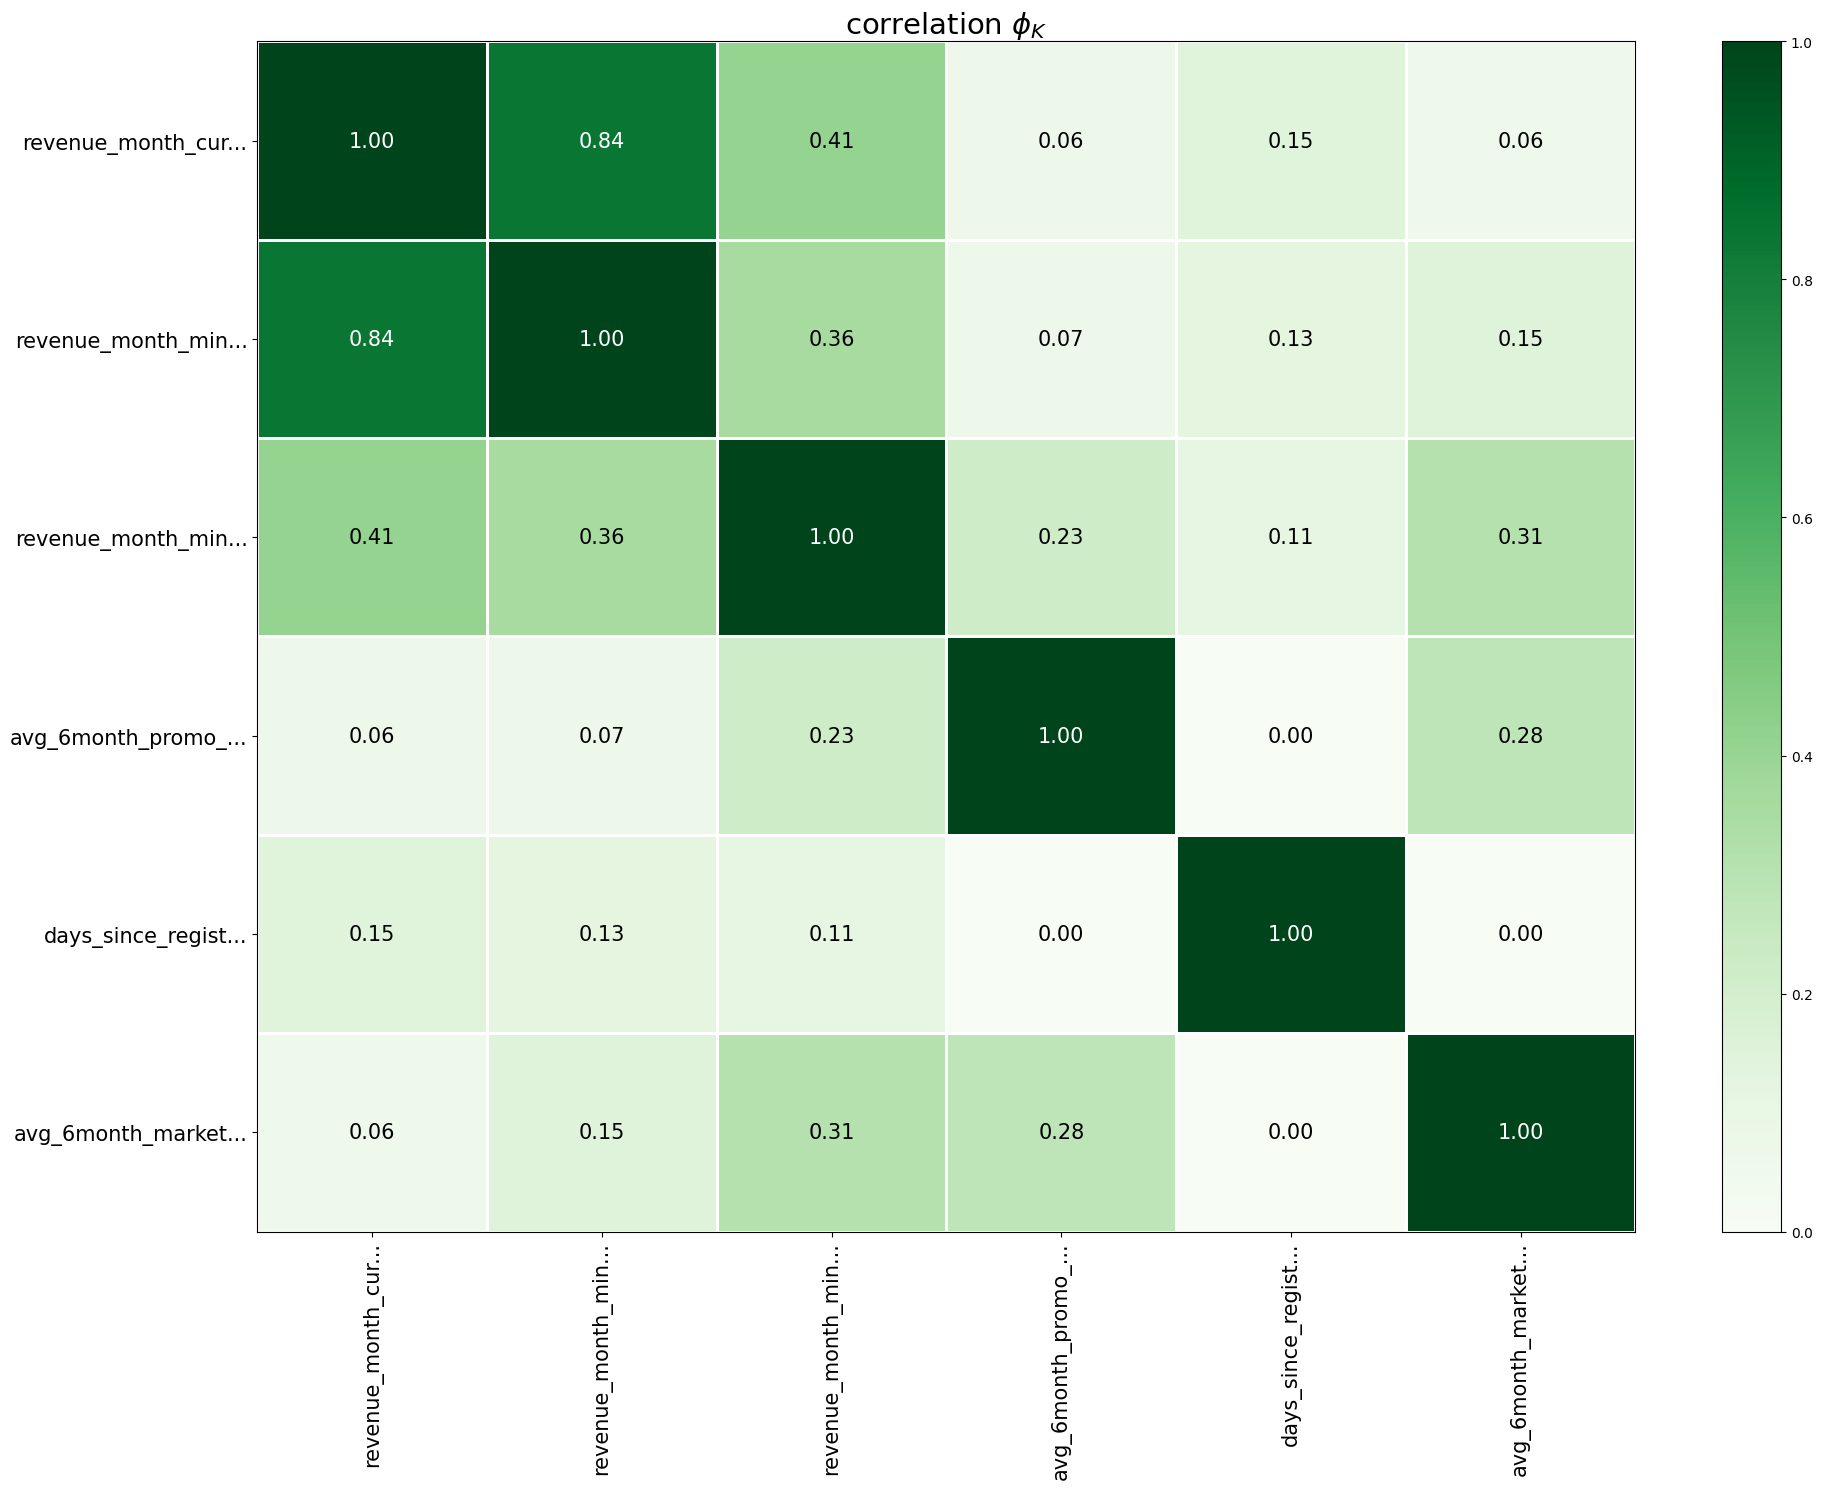

In [51]:
# Создаём список с наименованиями непрерывных признаков
interval_cols = ['avg_6month_marketing_activity', 'days_since_registration', 'avg_6month_promo_purchase_share', \
                 'revenue_month_minus_2', 'revenue_month_minus_1', 'revenue_month_current']

# Считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_active_users[interval_cols], interval_cols=interval_cols)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Промежуточные выводы

По результатам построения матрицы корреляции наблюдается высокая линейная зависимость между выручкой текущего и предыдущего месяцев. Оба признаки важны для построения модели, оставим их без изменений.

## Построение моделей

### Особенности данных

**Категориальные признаки**

* **OneHotEncoder** (2 признака), т.к. между категориями этих признаков нет естественной иерархии, а следовательно - математической связи:
  * popular_category
  * allow_communications
  
* **OrdinalEncoder** (3 признака):
  * service_type - стандартный сервис дешевле/проще чем премиум, можно выстроить порядок
  * session_cat_month_minus_1 - категории по длительности сессий имеют мат. обоснование
  * session_cat_month_current - аналогично

*Важное замечание* - в признаках отсутствуют пропуски

**Количественные признаки**

*Масштабирование* требуется для следующих признаков:

* `avg_6month_marketing_activity`
* `curr_month_marketing_activity`
* `days_since_registration`
* `avg_6month_promo_purchase_share`
* `avg_categories_viewed_per_session`
* `total_3month_unpaid_products`
* `total_3month_service_errors`
* `avg_3month_page_views_per_visit`
* `revenue_month_minus_2`
* `revenue_month_minus_1`
* `revenue_month_current`

### Формирование и работа с пайплайном

В качестве метрики для оценки качества модели выбрана метрика ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 

In [52]:
# ================== 0. Кодируем целевой признак ==================
le = LabelEncoder()
y_encoded = le.fit_transform(df_active_users['purchase_activity'])

# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(
    df_active_users.drop(['purchase_activity', 'user_id'], axis=1),
    y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_active_users['purchase_activity']) # Используем стратификацию целевого признака

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
ohe_columns = ['allow_communications', 'popular_category']
ord_columns = ['service_type', 'session_cat_month_minus_1', 'session_cat_month_current']
num_columns = [
    'avg_6month_marketing_activity',
    'curr_month_marketing_activity',
    'days_since_registration',
    'avg_6month_promo_purchase_share',
    'avg_categories_viewed_per_session',
    'total_3month_unpaid_products',
    'total_3month_service_errors',
    'avg_3month_page_views_per_visit',
    'revenue_month_minus_2',
    'revenue_month_minus_1',
    'revenue_month_current'
]

# ================== 3. Пайплайны обработки ==================

# OHE пайплайн
ohe_pipe = Pipeline([
                     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='error', sparse=False))
                    ]
                   )

# Ordinal пайплайн
ord_pipe = Pipeline(
    [
     ('ord', OrdinalEncoder(
         categories=[
             ['стандарт', 'премиум'],
             ['короткая', 'стандартная', 'длительная'],
             ['короткая', 'стандартная', 'длительная']
         ],
         handle_unknown='use_encoded_value', unknown_value=np.nan
             )
     )
     
    ]
)

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# ================== 5. Сетка параметров ==================

param_grid = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C':range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models':[SVC(
            kernel='poly',
            degree=6,
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

# ================== 6. RandomizedSearchCV ==================

# Инициализируем start для замера времени
start = time.time()

# Инициализируем класс для подбора гиперпараметров на 20 итераций
# значение кросс-валидации 5, метрика roc-auc
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search.fit(X_train, y_train)

# Считаем, сколько секунд прошло с начала запуска
randomized_search_search_time = time.time() - start
print(f'Search time:{randomized_search_search_time}')

# Выводим лучшую модель и метрики при обучении
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# ================== 7. Оценка на тестовой выборке ==================

# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

# ================== 8. Стратифицированная CV на всём датасете ==================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    randomized_search.best_estimator_,
    df_active_users.drop('purchase_activity', axis=1),
    df_active_users['purchase_activity'],
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC-AUC по стратифицированным фолдам:", cv_scores)
print("Средний ROC-AUC:", cv_scores.mean())
print("Стандартное отклонение:", cv_scores.std())

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

Search time:0.7625000476837158
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['allow_communications',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                      

In [53]:
df_shape = df_active_users.drop(["purchase_activity", "user_id"], axis=1).shape
df_train_shape = X_train.shape
df_test_shape = X_test.shape

# Проверим размерность тренировочной и тестовой выборок
display(f'Размерность исходной выборки {df_shape}')
display(f'Размерность тренировочной выборки {df_train_shape}')
display(f'Размерность тестовой выборки {df_test_shape}')

try:
    # Проверяем, что количество столбцов совпадает
    if df_train_shape[1] != df_test_shape[1]:
        raise ValueError("Количество столбцов в train и test не совпадает")
    display('Разбиение по столбцам проведено успешно!')
except Exception as e:
    print(f'Произошла ошибка: {e}')

'Размерность исходной выборки (1297, 16)'

'Размерность тренировочной выборки (972, 16)'

'Размерность тестовой выборки (325, 16)'

'Разбиение по столбцам проведено успешно!'

### Комментарии по итогам моделирования

* Лучшей моделью стала Логистическая регрессия с следующими параметрами: C=3, penalty='l1', random_state=42, solver='liblinear'
* Метрика лучшей модели на тренировочной выборке: 89.7%
* Метрика ROC-AUC на тестовой выборке: 92.1%
* Средний ROC-AUC по стратифицированным фолдам: 90.3%
* Стандартное отклонение: 2.3%

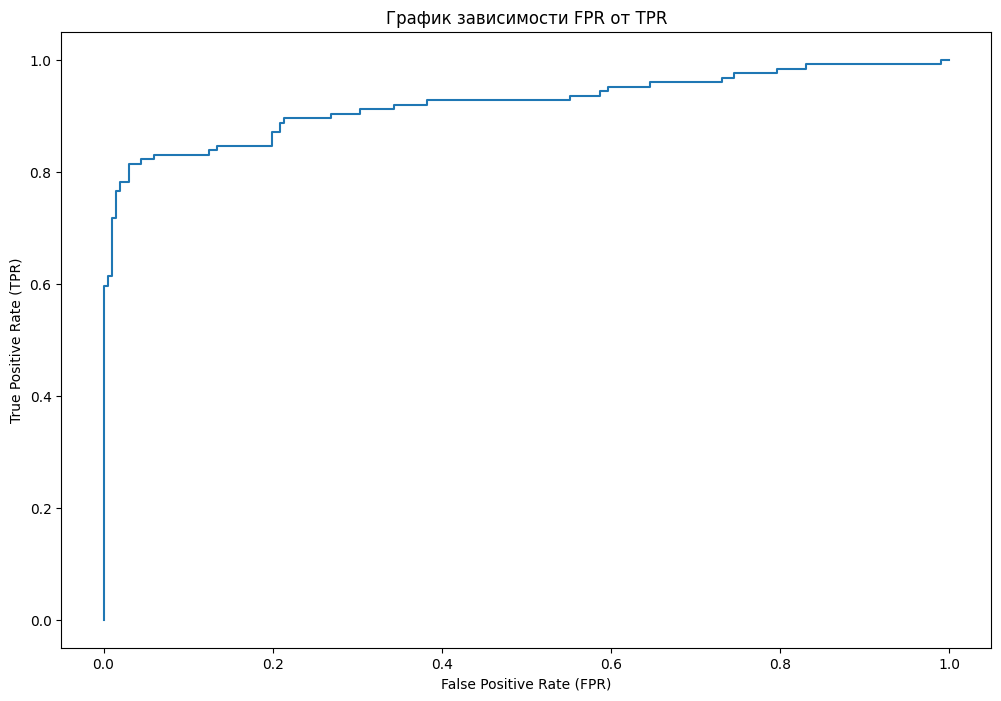

In [54]:
# рассчитайте значения FPR и TRP
fpr, tpr, threshold = roc_curve(y_test, y_test_pred, pos_label=1)

# постройте график зависимости FPR от TPR
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

##### Комментарий к графику

ROC-кривая меняет направляет в области выше 0.8

## Анализ важности признаков

### Подготовка фичей для вывода на графики

In [55]:
# Получаем препроцессор из пайплайна
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

# Преобразуем тренировочные и тестовые данные
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Получаем модель
model = randomized_search.best_estimator_.named_steps['models']

# Рассчитываем permutation importance
result = permutation_importance(
    model, 
    X_test_transformed, 
    y_test, 
    scoring='roc_auc'
)

# Собираем названия признаков правильно
# Сначала получаем все преобразованные признаки
all_features = []

# Добавляем OHE признаки
ohe_features = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)
all_features.extend(ohe_features)

# Добавляем Ordinal признаки (используем исходные названия)
all_features.extend(ord_columns)

# Добавляем числовые признаки
all_features.extend(num_columns)

# Добавляем оставшиеся признаки (если есть)
# Проверяем, все ли признаки учтены
remaining_features = X_test.columns[~X_test.columns.isin(ohe_columns + ord_columns + num_columns)]
all_features.extend(remaining_features)

# Проверяем соответствие размеров
assert X_test_transformed.shape[1] == len(all_features)
assert len(all_features) == len(result['importances_mean'])

# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': result['importances_mean']
})

feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Дополнительная проверка
print("Проверка соответствия размеров:")
print(f"Длина all_features: {len(all_features)}")
print(f"Длина importances_mean: {len(result['importances_mean'])}")
print(f"Форма преобразованных данных: {X_test_transformed.shape}")


Проверка соответствия размеров:
Длина all_features: 21
Длина importances_mean: 21
Форма преобразованных данных: (325, 21)


In [56]:
print("Длина features_names:", len(all_features))
print("Длина importances_mean:", len(result['importances_mean']))


Длина features_names: 21
Длина importances_mean: 21


In [57]:
print("Форма преобразованных данных:", X_test_transformed.shape)
print("Количество признаков:", len(all_features))
print("Длина importances_mean:", len(result['importances_mean']))
print("Пропуски в importances_mean:", np.isnan(result['importances_mean']).sum())
print("Тип importances_mean:", type(result['importances_mean']))
print("Тип all_features:", type(all_features))


Форма преобразованных данных: (325, 21)
Количество признаков: 21
Длина importances_mean: 21
Пропуски в importances_mean: 0
Тип importances_mean: <class 'numpy.ndarray'>
Тип all_features: <class 'list'>


### График важности признаков

[-0.04298361  0.22291106  0.          0.00950998 -0.86479664 -0.52656978
  0.08083858 -0.15305382 -0.68891237 -0.66774741 -0.56998611  0.02150343
  0.20747535  0.35123863 -1.02057171  0.84296659 -0.15255937 -1.04668837
 -0.48543387  0.47324608 -0.30548027]


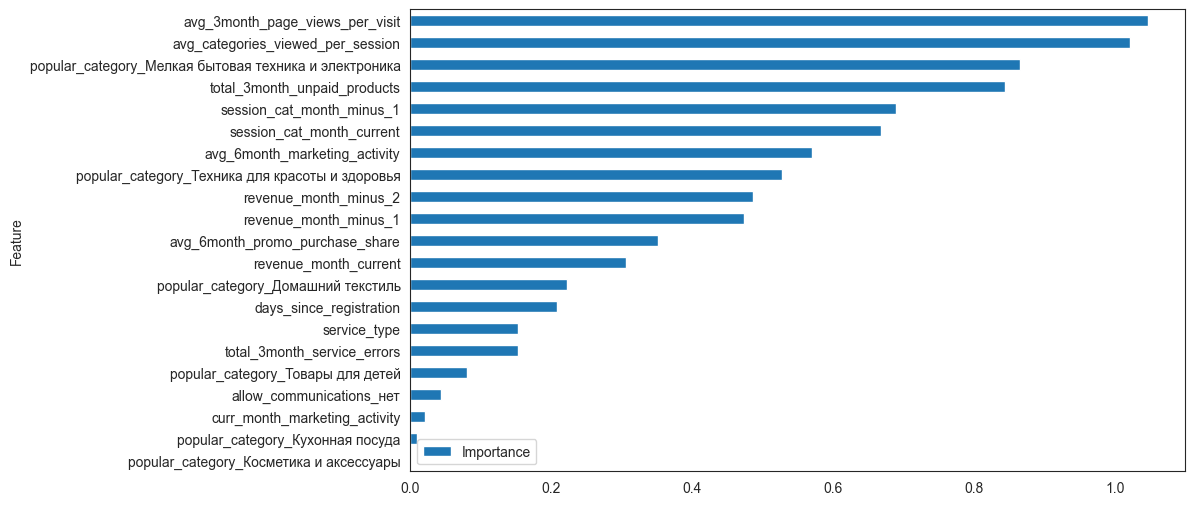

In [58]:
# Получаем модель из пайплайна
model = randomized_search.best_estimator_.named_steps['models']  # замените 'models' на имя вашего шага с моделью

# Определяем значения коэффициентов признаков для вывода на график
coefficients = model.coef_[0]
print(coefficients)

# Определяем значимость признаков
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)

# Строим график важности признаков
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

##### Комментарий к графику важности признаков

По результатам построения графика важности признаков обученной модели выявлено, что наиболее важными признаками являются:
* среднее количество просматриваемых страниц за одну сессию
* общее количество неоплаченных товаров в корзине
* итоговое время сессий в предыдущем и текущем месяцах
* среднее количество просматриваемых категорий товаров за одну сессию
* среднее количество маркетинговых коммуникаций с пользователем
* средняя доля покупок по акциям
* выручка в предыдущем и препредыдущем месяцах
* популярность категории "мелкая бытовая техника и электроника"

Посмотрим на то, как поменяется важность признаков при их поочерёдной рандомизации с помощью `permutation_importance`

### График важности признаков с учетом рандомизации

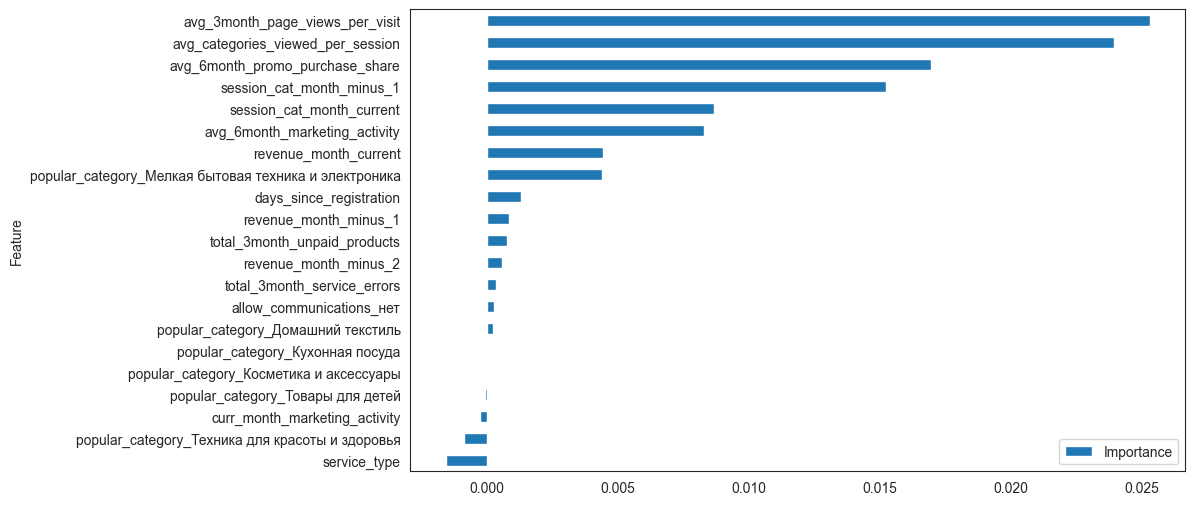

In [59]:
# Инициализируем перестановку признакой у модели
result = permutation_importance(model, X_test_transformed, y_test, scoring='roc_auc')

# Определяем значимость признаков
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Строим график важности признаков
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

##### Комментарий к графику важности признаков с учетом рандомизации

На графике видно, что результаты несколько изменились.

**Следующие признаки вносят шум или коррелируют с важными признаками**:
* выручка предыдущего месяца
* тип сервиса

**Следующие показатели остались важными**:
* среднее количество просматриваемых страниц за одну сессию
* итоговое время сессий в предыдущем и текущем месяцах
* средняя доля покупок по акциям
* среднее количество просматриваемых категорий товаров за одну сессию
* выручка в текущем и препредыдущем месяцах
* среднее количество маркетинговых коммуникаций с пользователем
* популярность категории "мелкая бытовая техника и электроника"

### График важности признаков по методку SHAP

#### График общей важности признаков

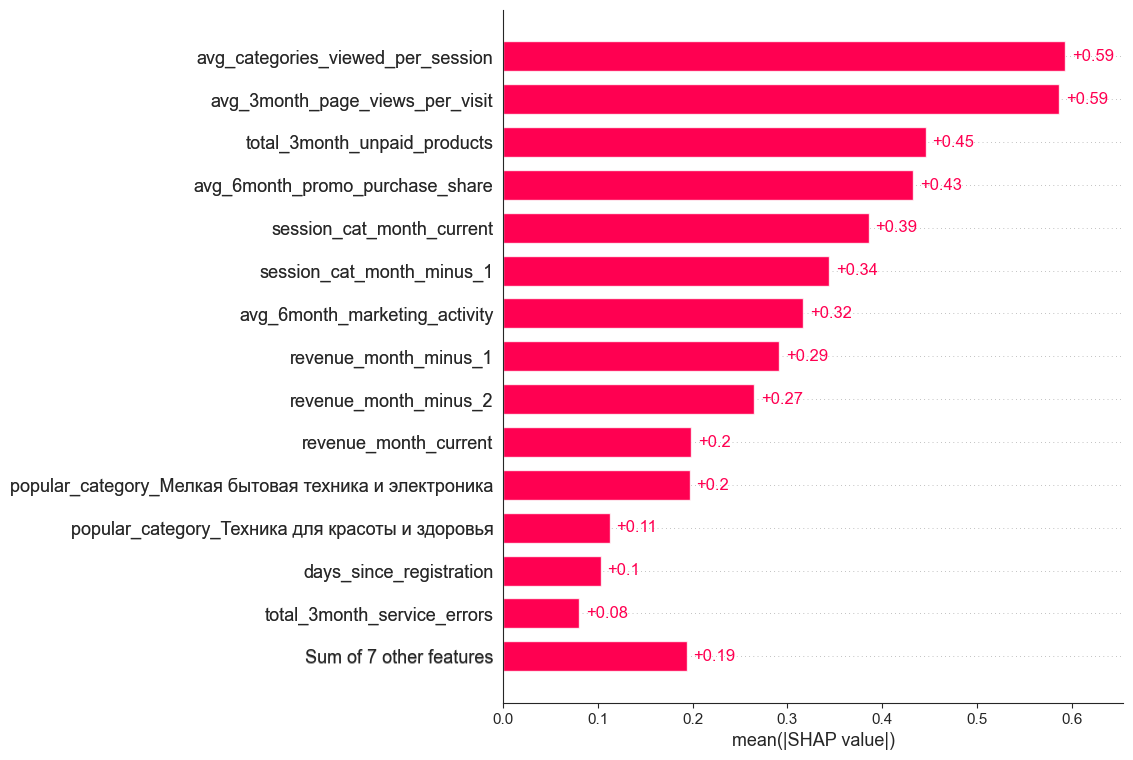

In [60]:
explainer = shap.LinearExplainer(model, pd.DataFrame(X_train_transformed, columns=all_features))
shap_values = explainer(pd.DataFrame(X_test_transformed, columns=all_features))

# строим график shap
shap.plots.bar(shap_values, max_display=15, show=False)
plt.show()

##### Комментарий к графику общей важности признаков

На этом графике видим, что ранее выявленные главные признаки остались прежними.

Далее рассмотрим влияние признаков на каждое предсказание.

#### График важности признаков для каждого предсказания Beeswarm

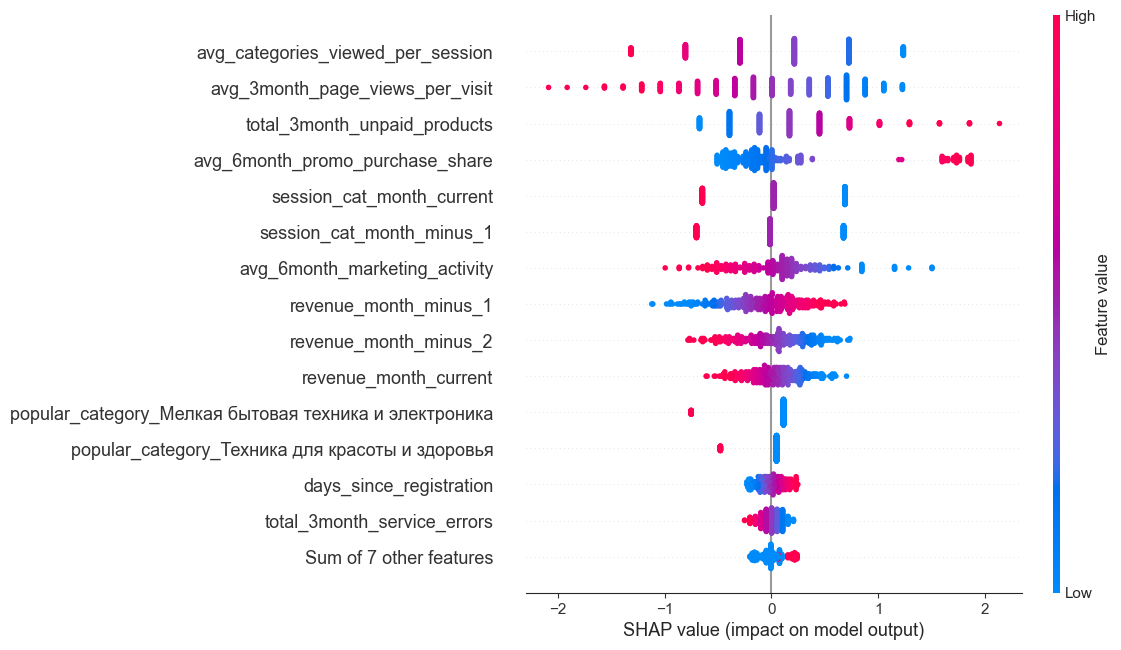

In [61]:
# Построим график влияния признаков на каждое предсказание модели
shap.plots.beeswarm(shap_values, max_display=15)

### Комментарий к графику важности признаков для каждого предсказания Beeswarm

Здесь мы видим любопытные результаты.

**Увеличение значений следующих признаков повышает вероятность оценки покупательской способности клиента как "Снизилась":**
* общее количество неоплаченных товаров в корзине
* средняя доля покупок по акциям
* выручка в предыдущем месяце
* количество дней с момента регистрации на сайте

**Если подумать логически, то такие результаты не лишены смысла:**
* С увеличением количества неоплаченных товаров в корзине можно предположить, что пользователь в какой-то момент оставляет покупку на потом, затем находит эти товары на другом сервисе и покупает их там
* Возможно, пользователь оставляет товар в корзине в ожидании промо-компаний или снижения цены
* Выручка в предыдущем месяце придает выручке текущего месяца маркер повышения или снижения (если в предыдущем месяце было больше, значит, активность снизилась, и наоборот)
* Чем дольше пользователь знает сервис, тем больше вероятность, что он в снизит активность, что тоже логично. Допустим, он хорошо знаком с сервисом, лучше знает, когда возможны акции, и вообще может "устать" от взаимодействия с этим продуктом, хочет разнообразия и изменения своих привычек в поисках чего-то нового

**Признаки ниже тоже могут хорошо интерпретировать покупательскую способность:**
* Среднее количество просматриваемых страниц за одну сессию - чем активнее пользователь, тем ниже вероятность перестать пользоваться продуктом
* Аналогичный вывод для признаков - итоговое время сессий в предыдущем и текущем месяцах и среднее количество просматриваемых категорий товаров за одну сессию
* Среднее количество маркетинговых коммуникаций с пользователем - активное взаимодействие с клиентом снижает вероятность забыть продукт
* Популярность категории "мелкая бытовая техника и электроника" - это товары с длинным жизненным циклом, пользователи могут приходить на сайт за ними, приобретать и уходить вплоть до появления новой потребности по этой категории спустя длительное время

## Сегментация покупателей

### Добавление данных о прибыльности клиентов

In [62]:
# Объединим датафрейм для моделирования с данными о прибыльности клиентов
df_profit_active_users = df_active_users.merge(df_profit.data, on='user_id', how='left')

# Смотрим на результат
df_profit_active_users.head()

,user_id,purchase_activity,service_type,allow_communications,avg_6month_marketing_activity,curr_month_marketing_activity,days_since_registration,avg_6month_promo_purchase_share,popular_category,avg_categories_viewed_per_session,total_3month_unpaid_products,total_3month_service_errors,avg_3month_page_views_per_visit,revenue_month_minus_2,revenue_month_minus_1,revenue_month_current,session_cat_month_minus_1,session_cat_month_current,avg_3month_profit
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,4472.00,5216.00,4971.60,стандартная,короткая,4.16
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,4826.00,5457.50,5058.40,короткая,стандартная,3.13
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,4793.00,6158.00,6610.40,стандартная,стандартная,4.87
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,4594.00,5807.50,5872.50,короткая,стандартная,4.21
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,5124.00,4738.50,5388.50,короткая,короткая,3.95


### Выделение сегмента высокоприбыльных клиентов

In [63]:
# Для начала сегментируем покупателей по прибыльности
df_profit_active_users['profit_cat'] = df_profit_active_users['avg_3month_profit'].apply(lambda x: 'низкий' if x <= 3 else 'средний' if 3 < x < 4 else 'высокий')

# Смотрим на распределение значений
df_profit_active_users['profit_cat'].value_counts()

высокий    671
средний    408
низкий     218
Name: profit_cat, dtype: int64

In [64]:
# Посмотрим на распределение популярных категорий среди высокоприбыльных юзеров 
df_high_profit = df_profit_active_users.query('profit_cat == "высокий"')

# Смотрим на результат
df_high_profit['popular_category'].value_counts()

Товары для детей                        178
Домашний текстиль                       125
Косметика и аксесcуары                  123
Мелкая бытовая техника и электроника     86
Техника для красоты и здоровья           83
Кухонная посуда                          76
Name: popular_category, dtype: int64

In [65]:
# Посмотрим на распределение высокоприбыльных клиентов по подпискам
df_high_profit['service_type'].value_counts()

стандарт    480
премиум     191
Name: service_type, dtype: int64

In [66]:
# Укрупним популярные категории товаров для последующего анализа
def categorize_products(popular_cat):
    if popular_cat == 'Домашний текстиль' or popular_cat == 'Кухонная посуда':
        return 'Товары для дома'
    elif popular_cat == 'Косметика и аксесуары' or popular_cat == 'Техника для красоты и здоровья':
        return 'Товары для себя'
    else:
        return popular_cat

# Создаем копию датасета во избежание ошибок
df_high_profit = df_high_profit.copy()

# Добавим столбец с категориями в датафрейм
df_high_profit['product_category'] = df_high_profit['popular_category'].apply(categorize_products)

# Смотрим на результат укрупнения категорий
df_high_profit_prod_cat = (df_high_profit[['product_category', 'purchase_activity']]
                                        .value_counts()
                                        .reset_index()
                                        .rename(columns={0:'count'})
                                        .sort_values(by='product_category')
                          )
# Смотрим результат
df_high_profit_prod_cat

,product_category,purchase_activity,count
5,Косметика и аксесcуары,Прежний уровень,64
6,Косметика и аксесcуары,Снизилась,59
4,Мелкая бытовая техника и электроника,Прежний уровень,71
9,Мелкая бытовая техника и электроника,Снизилась,15
1,Товары для детей,Прежний уровень,93
2,Товары для детей,Снизилась,85
0,Товары для дома,Прежний уровень,126
3,Товары для дома,Снизилась,75
7,Товары для себя,Прежний уровень,58
8,Товары для себя,Снизилась,25


### Анализ сегмента высокоприбыльных клиентов

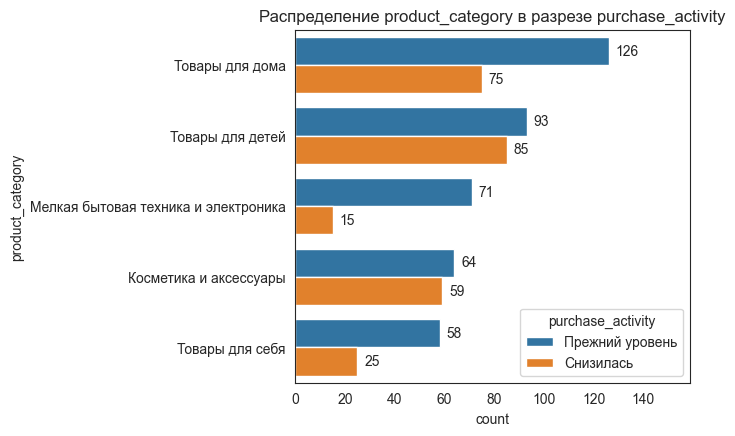

In [67]:
# Инициализируем объект для визуализации
viz_high_profit = Visualizer(df_high_profit)

# Выводим график на экран
viz_high_profit.barplot(x='product_category', hue='purchase_activity')

In [68]:
# Создаем список, который задаст порядок столбцов в сводной таблице
columns_order = ['total_3month_unpaid_products', 
                 'avg_6month_promo_purchase_share',
                 'days_since_registration',
                 'revenue_month_minus_2',
                 'revenue_month_minus_1', 
                 'revenue_month_current',
                 'avg_3month_page_views_per_visit', 
                 'avg_6month_marketing_activity'
                 ]

# Формируем сводную таблицу
(df_high_profit\
    .query('purchase_activity == "Снизилась" and product_category != "Мелкая бытовая техника и электроника"')
    .pivot_table(
        index=['service_type', 'product_category', 'allow_communications'],
        values=columns_order
    )
 [columns_order]
)

total_3month_unpaid_products  \
service_type product_category       allow_communications                                 
премиум      Косметика и аксесcуары да                                            3.56   
                                    нет                                           3.00   
             Товары для детей       да                                            3.18   
                                    нет                                           3.00   
             Товары для дома        да                                            3.62   
                                    нет                                           4.80   
             Товары для себя        да                                            4.00   
стандарт     Косметика и аксесcуары да                                            2.85   
                                    нет                                           3.50   
             Товары для детей       да                                            3.98   
                                    нет                                           2.90   
             Товары для дома        да                                            4.00   
                                    нет                                           4.68   
             Товары для себя        да                                            5.50   
                                    нет                                           1.00   

                                                          avg_6month_promo_purchase_share  \
service_type product_category       allow_communications                                    
премиум      Косметика и аксесcуары да                                               0.35   
                                    нет                                              0.33   
             Товары для детей       да                                               0.63   
                                    нет                                              0.28   
             Товары для дома        да                                               0.38   
                                    нет                                              0.52   
             Товары для себя        да                                               0.35   
стандарт     Косметика и аксесcуары да                                               0.49   
                                    нет                                              0.49   
             Товары для детей       да                                               0.47   
                                    нет                                              0.44   
             Товары для дома        да                                               0.47   
                                    нет                                              0.48   
             Товары для себя        да                                               0.40   
                                    нет                                              0.23   

                                                          days_since_registration  \
service_type product_category       allow_communications                            
премиум      Косметика и аксесcуары да                                     695.20   
                                    нет                                    818.00   
             Товары для детей       да                                     760.47   
                                    нет                                    553.33   
             Товары для дома        да                                     807.23   
                                    нет                                    643.20   
             Товары для себя        да                                     810.12   
стандарт     Косметика и аксесcуары да                                     572.65   
                                    нет                                    527.08   
          

In [69]:
# Далее посмотрим, как наличие согласия о получении рассылок влияет на уровень выручки
(df_high_profit\
    .query('purchase_activity == "Снизилась" and product_category != "Мелкая бытовая техника и электроника"')\
    .groupby(['service_type', 'allow_communications'])[['revenue_month_minus_2', 'revenue_month_minus_1','revenue_month_current']]\
    .sum()
)

revenue_month_minus_2  \
service_type allow_communications                          
премиум      да                                293887.00   
             нет                                45736.00   
стандарт     да                                553336.00   
             нет                               247379.00   

                                   revenue_month_minus_1  \
service_type allow_communications                          
премиум      да                                313837.00   
             нет                                53840.50   
стандарт     да                                572798.00   
             нет                               264260.50   

                                   revenue_month_current  
service_type allow_communications                         
премиум      да                                338097.60  
             нет                                56714.80  
стандарт     да                                610548.80  
             нет                               279967.10

### Промежуточные выводы

По данным о выручке от пользователей разных категорий (премиум / стандарт) видно, что бОльшую выручку приносят клиенты с согласием на рассылки и пр. коммуникации.



Из общей выборки клиентов мы выделили самых прибыльных (выше 4 у.е.) по данным финансового департамента.

В рамках подготовки к анализу активности по сегментам мы укрупнили категории товаров до следующей структуры:
* Товары для себя
* Товары для дома
* Товары для детей
* Мелкая бытовая техника и электроника

Далее мы рассмотрели долю снижения покупательской активности в разрезе укрупненных категорий товаров. Самая низкая доля снижения оказалась у категории "Мелкая бытовая техника и электроника", последующий анализ проводился без этой категории товара.

Далее мы взяли наиболее важные признаки по итогам моделирования. Повторимся, что по результатам моделирования мы выявили, что вероятность перехода пользователя в категорию снижения покупательской способности растет с увеличением таких показателей, как:
* общее количество неоплаченных товаров в корзине
* средняя доля покупок по акциям
* выручка в предыдущем месяце
* количество дней с момента регистрации на сайте

Далее высокоприбыльных клиентов мы разделили по типу подписки (премиум, стандарт) и получили следующие результаты:

1. Если говорить о премиум клиентах, то среднее количество неоплаченных продуктов выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**
2. Если говорить о клиентах категории стандарт, то среднее количество неоплаченных продуктов выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**

1. Если говорить о премиум клиентах, то доля покупок по акциям выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**
2. Если говорить о клиентах категории стандарт, то доля покупок по акциям выше в категориях:
    * "Товары для детей" у клиентов **с согласием на рассылки**
    * "Товары для себя", "Товары для дома" у клиентов **без согласия на рассылки**

    
* среднее количество неоплаченных продуктов и доля покупок по акциям выше у клиентов, не получающих дополнительные предложения о товарах (исключение составили клиенты с типом сервиса "стандарт" в категории "Товары для детей")
* при этом сегмент пользователей, не дающих согласие на получение доп. предложений, в целом зарегистрировались позже клиентов с наличием такого согласия

Самая высокая доля покупок по акциям в премиум-сегменте - в категории "Товары для детей" (63% с согласием на рассылки), "Товары для дома" (52% без согласия на рассылки).

Если же говорить о признаках, с увеличением которых растет вероятность сохранения покупательской активности, то:
* у клиентов с подпиской "премиум" и отсутствием согласия на рассылки, ниже среднее количество просматриваемых страниц за сессию
* у клиентов с подпиской "стандарт" и отсутствием согласия на рассылки, наоборот, просмотры страниц за сессию выше чем у тех, кто согласился на рассылки (кроме товаров для дома), но при этом и выше среднее значение маркетинговых коммуникаций (рассылок, звонков, показов рекламы и прочего)

### Рекомендации

1. Следует проверить на достоверность гипотезу об измении программы лояльности для премиум-клиентов - возможно, с таким пакетом клиенты ожидают более гибкое ценообразование на "Товары для детей" и "Товары для себя", учитывая высокие значения по неоплаченным товарам и долю покупок по акциям.
2. Эти показатели также следует проверить, получив доп. информацию о стоимости доставки и способах получения товара: возможно, клиенты ждут акций по бесплатной доставке. Может, рядом нет удобного пункта выдачи товара.
3. Возможно, следует пересмотреть перечень фишек при приобретении пакета премиум - чтобы увеличить сегмент, обеспечивающий постоянный денежный поток.
4. Также есть смысл посмотреть, как устроена работа с брошенной корзиной. Возможно, следует направлять триггерные смс-сообщения или уведомления в приложении, если накапливается от 2-х продуктов и выше. А также добавить бесплатную доставку при завершении брошенного заказка от 4 товаров.
5. Можно добавить повышенные бонусы для клиентов без согласия на рассылки при завершении брошенного заказа от 3 товаров и выше.
6. Если клиент часто покупает какие-то позиции, то можно предложить персональные цены на эти позиции (например, "любимый продукт").

## Общий вывод

**Итоги этапа загрузки данных и анализа общей информации**
**df_market**

* **Количество строк:** 1300
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_revenue**

* **Количество строк:** 3900
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_time**

* **Количество строк:** 2600
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** корректировка не требуется

**df_profit**

* **Количество строк:** 1300
* **Пропущенные значения:** отсутствуют
* **Необходимые преобразования:**
  * Перевести наименования столбцов на английский язык
  * Привести к формату snake_case
* **Типы данных:** требуется корректировка
  * Прибыль -> float

--- 

**Итоги этапа предобработки данных**
* Тип данных для столбца `profit` датасета **df_profit** изменен на float64
* Имена столбцов унифицированы: приведены к виду snake_case, переведены на английский язык
* Явные и неявные дубликаты обработаны

---

**Итоги исследовательского анализа данных**

**Диаграммы размаха**

**df_market**

* **Ниже указаны медианы значений по признакам:**
  * `days_since_registration`: 600 (МР в диапазоне 400-800)
  * `avg_6month_promo_purchase_share`: 0.2 (МР в диапазоне 0.18-0.3)
  * `avg_6month_marketing_activity`: 4.2
* **Обнаружены выбросы по признакам:**
  * `avg_6month_promo_purchase_share` в области более 0.5

**df_revenue**

* **Медиана значений по признаку** `revenue_per_month` составила 5000 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6500 у.е. и ниже 3000 у.е.
* **Наибольшая сумма выручки:** зафиксирована в текущем месяце, но если говорить о средних значениях, то они аналогичны для всех 3-х периодов и держатся в районе 5000 у.е.

**df_time**

* **Медиана значений по признаку** `session_minutes` составила 13 минут
* **Выбросы не обнаружены**

**df_profit**

* **Медиана значений по признаку** `avg_3month_profit` составила 4 у.е.
* **Обнаружены выбросы в интервалах значений:** выше 6.5 у.е. и ниже 1.5 у.е.


**Гистограммы (количественные признаки)**

**df_market**

  * `avg_6month_marketing_activity`: распределение с пиком в области 4
  * `days_since_registration`: распределение с относительно пологими склонами, модальное значение наблюдается при значении 500 дней со дня регистрации
  * `avg_6month_promo_purchase_share`: распределение с пиком в области 0.2, заметен локальный пик в области 0.9-1.0

**df_revenue**

* `revenue_per_month`: распределение имеет нормальный характер с пиком в области 5000 у.е., на график видны редкие значения на интервале от 0 до 3000 у.е.

**df_time**

* `session_minutes`: распределение с модальными значениями на интервале 12-13 минут, также имеются пустоты в интервалах 10-11 минут, 16-17 минут

**df_profit**

* `avg_3month_profit`: распределение имеет нормальный характер с пиком в области 4.5 у.е.


**Столбчатые диаграммы (категорильаные признаки)**

**df_market** выборка обладает следующими характеристиками:

  * `purchase_activity`: большая чать клиентов относится к категории с постоянной покупательской способностью

Коммуникации с клиентом
  * `service_type`: клиент имеет подписку "стандарт"
  * `allow_communications`: клиент даёт разрешение на доп. предложения о товарах
  * `curr_month_marketing_activity`: клиент получает 4 уведомления в месяц
  * `avg_3month_page_views_per_visit`: клиент смотрит за сессию 4-11 страниц

Продуктовое поведение
  * `popular_category`: клиент чаще просматривает категории "товары для детей", "домашний текстиль", "косметика и аксессуары"
  * `avg_categories_viewed_per_session`: клиент просматривают 2-3 категории за одную сессию
  * `total_3month_unpaid_products`: клиент оставляет в корзине 1-2 неоплаченных товара

Поведение на сайте
  * `total_3month_service_errors`: клиент сталкивается с 4 сбоями при посещении сайта за последние 3 месяца


**df_revenue** и **df_time**

* Выборка по времени равномерная.

---


**Итоги корреляционного анализа данных**

**Категориальные признаки**

* **OneHotEncoder** (2 признака), т.к. между категориями этих признаков нет естественной иерархии, а следовательно - математической связи:
  * popular_category
  * allow_communications

* **OrdinalEncoder** (3 признака):
  * service_type - премиум обычно имеет стоимостное выражение выше
  * session_cat_month_minus_1 - категории по длительности сессий имеют мат. обоснование
  * session_cat_month_current - аналогично

*Важное замечание* - в признаках отсутствуют пропуски

**Количественные признаки**

*Масштабирование* требуется для следующих признаков:

* `avg_6month_marketing_activity`
* `curr_month_marketing_activity`
* `days_since_registration`
* `avg_6month_promo_purchase_share`
* `avg_categories_viewed_per_session`
* `total_3month_unpaid_products`
* `total_3month_service_errors`
* `avg_3month_page_views_per_visit`
* `revenue_month_minus_2`
* `revenue_month_minus_1`
* `revenue_month_current`

---

**Итоги этапа моделирования**

* В качестве метрики оценки качестве модели выбрана метрика ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного
* Лучшей моделью стала Логистическая регрессия с следующими параметрами: C=3, penalty='l1', random_state=42, solver='liblinear'
* Метрика лучшей модели на тренировочной выборке: 89.7%
* Метрика ROC-AUC на тестовой выборке: 92.1%
* Средний ROC-AUC по стратифицированным фолдам: 90.3%
* Стандартное отклонение: 2.3%
* Результат говорит о стабильно высокой прогнозной способности модели

---

**Итоги анализа важности признаков**

**Увеличение значений следующих признаков повышает вероятность оценки покупательской способности клиента как "Снизилась":**
* общее количество неоплаченных товаров в корзине
* средняя доля покупок по акциям
* выручка в предыдущем месяце
* количество дней с момента регистрации на сайте

**Если подумать логически, то такие результаты не лишены смысла:**
* С увеличением количества неоплаченных товаров в корзине можно предположить, что пользователь в какой-то момент оставляет покупку на потом, затем находит эти товары на другом сервисе и покупает их там
* Возможно, пользователь оставляет товар в корзине в ожидании промо-компаний или снижения цены
* Выручка в предыдущем месяце придает выручке текущего месяца маркер повышения или снижения (если в предыдущем месяце было больше, значит, активность снизилась, и наоборот)
* Чем дольше пользователь знает сервис, тем больше вероятность, что он в снизит активность, что тоже логично. Допустим, он хорошо знаком с сервисом, лучше знает, когда возможны акции, и вообще может "устать" от взаимодействия с этим продуктом, хочет разнообразия и изменения своих привычек в поисках чего-то нового

**Признаки ниже тоже могут хорошо интерпретировать покупательскую способность:**
* Среднее количество просматриваемых страниц за одну сессию - чем активнее пользователь, тем ниже вероятность перестать пользоваться продуктом
* Аналогичный вывод для признаков - итоговое время сессий в предыдущем и текущем месяцах и среднее количество просматриваемых категорий товаров за одну сессию
* Среднее количество маркетинговых коммуникаций с пользователем - активное взаимодействие с клиентом снижает вероятность забыть продукт
* Популярность категории "мелкая бытовая техника и электроника" - это товары с длинным жизненным циклом, пользователи могут приходить на сайт за ними, приобретать и уходить вплоть до появления новой потребности по этой категории спустя длительное время

---

**Итоги этапа сегментации покупателей**

Из общей выборки клиентов мы выделили самых прибыльных (выше 4 у.е.) по данным финансового департамента.

В рамках подготовки к анализу активности по сегментам мы укрупнили категории товаров до следующей структуры:
* Товары для себя
* Товары для дома
* Товары для детей
* Мелкая бытовая техника и электроника

Далее мы рассмотрели долю снижения покупательской активности в разрезе укрупненных категорий товаров. Самая низкая доля снижения оказалась у категории "Мелкая бытовая техника и электроника", последующий анализ проводился без этой категории товара.

Далее мы взяли наиболее важные признаки по итогам моделирования. Повторимся, что по результатам моделирования мы выявили, что вероятность перехода пользователя в категорию снижения покупательской способности растет с увеличением таких показателей, как:
* общее количество неоплаченных товаров в корзине
* средняя доля покупок по акциям
* выручка в предыдущем месяце
* количество дней с момента регистрации на сайте

Далее высокоприбыльных клиентов мы разделили по типу подписки (премиум, стандарт) и получили следующие результаты:

1. Если говорить о премиум клиентах, то среднее количество неоплаченных продуктов выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**
2. Если говорить о клиентах категории стандарт, то среднее количество неоплаченных продуктов выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**

1. Если говорить о премиум клиентах, то доля покупок по акциям выше в категориях:
    * "Товары для детей", "Товары для себя" у клиентов **с согласием на рассылки**
    * "Товары для дома" у клиентов **без согласия на рассылки**
2. Если говорить о клиентах категории стандарт, то доля покупок по акциям выше в категориях:
    * "Товары для детей" у клиентов **с согласием на рассылки**
    * "Товары для себя", "Товары для дома" у клиентов **без согласия на рассылки**

    
* среднее количество неоплаченных продуктов и доля покупок по акциям выше у клиентов, не получающих дополнительные предложения о товарах (исключение составили клиенты с типом сервиса "стандарт" в категории "Товары для детей")
* при этом сегмент пользователей, не дающих согласие на получение доп. предложений, в целом зарегистрировались позже клиентов с наличием такого согласия

Самая высокая доля покупок по акциям в премиум-сегменте - в категории "Товары для детей" (63% с согласием на рассылки), "Товары для дома" (52% без согласия на рассылки).

Если же говорить о признаках, с увеличением которых растет вероятность сохранения покупательской активности, то:
* у клиентов с подпиской "премиум" и отсутствием согласия на рассылки, ниже среднее количество просматриваемых страниц за сессию
* у клиентов с подпиской "стандарт" и отсутствием согласия на рассылки, наоборот, просмотры страниц за сессию выше чем у тех, кто согласился на рассылки (кроме товаров для дома), но при этом и выше среднее значение маркетинговых коммуникаций (рассылок, звонков, показов рекламы и прочего)

---

**Рекомендации**

1. Следует проверить на достоверность гипотезу об измении программы лояльности для премиум-клиентов - возможно, с таким пакетом клиенты ожидают более гибкое ценообразование на "Товары для детей" и "Товары для себя", учитывая высокие значения по неоплаченным товарам и долю покупок по акциям.
2. Эти показатели также следует проверить, получив доп. информацию о стоимости доставки и способах получения товара: возможно, клиенты ждут акций по бесплатной доставке. Может, рядом нет удобного пункта выдачи товара.
3. Возможно, следует пересмотреть перечень фишек при приобретении пакета премиум - чтобы увеличить сегмент, обеспечивающий постоянный денежный поток.
4. Также есть смысл посмотреть, как устроена работа с брошенной корзиной. Возможно, следует направлять триггерные смс-сообщения или уведомления в приложении, если накапливается от 2-х продуктов и выше. А также добавить бесплатную доставку при завершении брошенного заказка от 4 товаров.
5. Можно добавить повышенные бонусы для клиентов без согласия на рассылки при завершении брошенного заказа от 3 товаров и выше.
6. Если клиент часто покупает какие-то позиции, то можно предложить персональные цены на эти позиции (например, "любимый продукт").